__Import Libraries__

In [91]:
from ultralytics import YOLO
from pathlib import Path
from collections import defaultdict
from hungarian import * 
from pprint import pprint 
import torch
import json
import math
import numpy as np
import matplotlib.pyplot as plt
%run Radar_Clustering_CustomDBScan.py

__Path Definition__

In [92]:
path_to_images = Path(r'C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data')
path_to_pcd = Path(r'C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\radar_01\radar_01__data')

image_list = sorted(list(image for image in path_to_images.iterdir()))
pcd_list = sorted(list(image for image in path_to_pcd.iterdir()))

yolo_model = YOLO(r"C:\Dk\Projects\Team Project\YOLO detection\Models\Harshit_Large\large_300 epoch_batch 4_augmented\train32\weights\best.pt")
radar_cluster = r'C:\Dk\Projects\Team Project\Data Association\radar_camera_fusion.py'

calibration_file = Path(r"C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\calibration.json")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


__Function to Process YOLO prediction results__

In [93]:
def class_box_generator_for_pred(prediction_results):
    for result in prediction_results:
        cls = result.boxes.cls.cpu().numpy()
        conf = result.boxes.conf.cpu().numpy()
        detection = result.boxes.xyxy.cpu().numpy()

        list_of_pred_boxes = np.column_stack((cls, detection, conf))
    
    return list_of_pred_boxes

__Import Calibration Matrix__

In [94]:
sensor_calibration_dict = {
    "camera_intrinsics": [],
    "camera_distcoeffs": [],
    "radar_to_camera": [],
    "radar_to_lidar": [],
    "lidar_to_ground": [],
    "camera_to_ground": []
}

with open(calibration_file, 'r') as f:
    data = json.load(f)

for item in data['calibration']:
    if item['calibration'] == 'camera_01':
        sensor_calibration_dict['camera_intrinsics'] = item['k']
        sensor_calibration_dict['camera_distcoeffs'] = item['D']
    elif item['calibration'] == 'radar_01_to_camera_01':
        sensor_calibration_dict['radar_to_camera'] = item['T']
    elif item['calibration'] == 'radar_01_to_lidar_01':
        sensor_calibration_dict['radar_to_lidar'] = item['T']
    elif item['calibration'] == 'lidar_01_to_ground':
        sensor_calibration_dict['lidar_to_ground'] = item['T']
    elif item['calibration'] == 'camera_01_to_ground_homography':
        sensor_calibration_dict['camera_to_ground'] = item['T']


__Calibration: Radar to Ground__

In [95]:
def radar_to_ground_transfomer(points_array, T_radar_to_lidar, T_lidar_to_ground):

    n_p_array = np.array(points_array).reshape(1,-1)
    tranposed_array = np.transpose(n_p_array)
   
    row_of_ones = np.ones((1, 1))           #1x1
    stacked_matrix = np.vstack((tranposed_array, row_of_ones))  
  
    radar_to_lidar_matrix = np.matmul(T_radar_to_lidar, stacked_matrix)             #3x1

    new_stacked_matrix = np.vstack((radar_to_lidar_matrix, row_of_ones))             #4x1
    in_ground_data = np.matmul(T_lidar_to_ground, new_stacked_matrix)


    in_ground = np.transpose(in_ground_data)

    return in_ground[0]


__Radar dict: on Ground__

In [96]:
def radar_to_ground(radar_dict):
    
    T = sensor_calibration_dict['radar_to_lidar']
    K = sensor_calibration_dict['lidar_to_ground']

    in_radar = radar_dict
    in_ground = {'cluster': [], 'noise': []}
    for key, value in in_radar.items():
        if key == 'cluster':
            for point in value:
                if point:
                    updated_centroid = radar_to_ground_transfomer(point[0], T, K)
                    updated_lowest_point = radar_to_ground_transfomer(point[1], T, K)
                    updated_velocity = point[2]
                    updated_velocity
                    updated_point = [list(updated_centroid), list(updated_lowest_point), list(updated_velocity)]

                    if key in in_ground:
                        in_ground[key].append(updated_point)
                    else:
                        print('no key exist')
        else:
            for point in value:
                if point:
                    updated_centroid = radar_to_ground_transfomer(point[0], T, K)
                    updated_velocity = [point[1]]
                    updated_point = [list(updated_centroid), list(updated_velocity)]

                    if key in in_ground:
                        in_ground[key].append(updated_point)
                    else:
                        print('no key exist')
                    
    return in_ground

__Calibration: Radar to Image__

In [97]:
def radar_to_camera_transformer(radar_point, T, k):
   
    n_p_array = np.array(radar_point).reshape(1,-1)
    transpose_RPA = np.transpose(n_p_array)

    new_array = np.vstack([transpose_RPA, np.ones((1, 1))])             
    product_1 = np.matmul(np.array(k), np.array(T))

    product_array = np.matmul(product_1, new_array)                      #[su, sv, s] but along column

    final_array = product_array / product_array [2]                      #[u, v, 1], along column

    u_v = np.delete(final_array, 2, axis = 0)                            #[u, v], along column      
    final_u_v = np.transpose(u_v)

    return final_u_v[0]

__Radar dict: on Image__

In [98]:
def radar_to_camera(radar_output):
    T =  sensor_calibration_dict['radar_to_camera']
    K = sensor_calibration_dict['camera_intrinsics']
    
    in_radar = radar_output
    in_camera = {'cluster': [], 'noise': []}
    for key, value in in_radar.items():
        if key == 'cluster':
            for point in value:
                if point:
                    updated_centroid = radar_to_camera_transformer(point[0], T, K)
                    updated_lowest_point = radar_to_camera_transformer(point[1], T, K)
                    updated_velocity = point[2]
                    updated_point = [list(updated_centroid), list(updated_lowest_point), list(updated_velocity)]

                    if key in in_camera:
                        in_camera[key].append(updated_point)
                    else:
                        print('no key exist')
        else:
            for point in value:
                if point:
                    updated_centroid = updated_centroid = radar_to_camera_transformer(point[0], T, K)
                    updated_velocity = [point[1]]
                    updated_point = [list(updated_centroid), list(updated_velocity)]

                    if key in in_camera:
                        in_camera[key].append(updated_point)
                    else:
                        print('no key exist')
    
    return in_camera

__Homography: Image to Ground__

In [99]:
def homography(list_of_pred_boxes):
    ground_coordinate_list = []
    for result in list_of_pred_boxes:
        bbox = list(result[1:5])
    
        # x1y1 = np.array(bbox[:2]).reshape(1, -1)
        # x2y2 = np.array(bbox[2:]).reshape(1, -1)
        bottom_center_point = np.array(list(((bbox[2] + bbox[0]) / 2, bbox[3]))).reshape(1, -1) 

        # image_coordinates = np.concatenate((x1y1,x2y2,bottom_center_point), axis=0)
        # image_coordinates = np.concatenate((bottom_center_point), axis=0)
        transpose_matrix = np.vstack((np.transpose(bottom_center_point),np.ones((1,1))))
        
        homogeneous_coordinates = np.matmul(sensor_calibration_dict['camera_to_ground'], transpose_matrix)
        ground_coordinates = homogeneous_coordinates / homogeneous_coordinates[-1].reshape(1, -1)

        transpose_ground_coordinates = ground_coordinates.T
        g_x1y1 = transpose_ground_coordinates[0][:2]
        # g_x2y2 = transpose_ground_coordinates[1][:2]
        # g_xcyc = transpose_ground_coordinates[2][:2]

        # ground_coordinate_list.append([list(g_x1y1), list(g_x2y2), list(g_xcyc)])
        ground_coordinate_list.append([list(g_x1y1)])

    # print(ground_coordinate_list)
    return ground_coordinate_list

__Visualization: Camera Points on Ground Plane__

In [100]:
def camera_plotting(image_on_ground):
        x_plotting_list = []
        y_plotting_list = []

        for points in image_on_ground:
                x_coords = [point[0] for point in points]
                y_coords = [point[1] for point in points]

                x_plotting_list.append(x_coords)
                y_plotting_list.append(y_coords)
        
        colors = ['blue', 'green', 'orange', 'black', 'purple', 'maroon']

        fig, my_plot = plt.subplots()
        for i, (x_co, y_co) in enumerate(zip(x_plotting_list, y_plotting_list)):
        # Plot the points
                my_plot.scatter(x_co, y_co, color=colors[i], label= 'camera')

        # Add labels and title
        my_plot.set_xlabel('X-axis')
        my_plot.set_ylabel('Y-axis')
        my_plot.set_title('Plot of Points')
        
        # Show the plot
        return my_plot

__Visualization: Radar points on Ground Plane__

In [101]:
def radar_plotting(dict, my_plot):
    clusters = dict['cluster']
    noise_points = dict['noise']

    x_lowest = []
    y_lowest = []

    x_noise = []
    y_noise = []

    for detection in clusters:
        if len(detection) != 0:
            lowest_point = detection[1]
            x_lp = lowest_point[0]
            y_lp = lowest_point[1]
            x_lowest.append(x_lp)
            y_lowest.append(y_lp)
    
    for noise in noise_points:
        if len(noise) != 0:
            lowest_point = noise[0]
            x_n = lowest_point[0]
            y_n = lowest_point[1]
            x_noise.append(x_n)
            y_noise.append(y_n)


    # Plotting new points on the existing graph
    my_plot.scatter(x_lowest, y_lowest, color='red', label='lowest point')
    my_plot.scatter(x_noise, y_noise, color='grey', label='Noise')

    # Adding legend if it's not already added
    if not my_plot.get_legend():
        my_plot.legend()

    return my_plot

__Association: One to One__

In [102]:
'''
def get_one_one_association(list_of_pred_boxes, cluster_on_image):
    clusters = cluster_on_image['cluster']
    noise_points = cluster_on_image['noise']
    
    # Keep track of which clusters and bounding boxes have been associated
    associated_clusters = set()
    associated_boxes = set()
    
    for prediction in list_of_pred_boxes:
        bbox = prediction[1:5]  
        associated = False
        for cluster in clusters:
            cluster_centroid = cluster[0]
            
            if bbox[0] < cluster_centroid[0] < bbox[2] and bbox[1] < cluster_centroid[1] < bbox[3]:
                
                # If this cluster or bounding box has already been associated, remove it from associated and add it to non_associated
                if cluster_centroid in associated_clusters or bbox in associated_boxes:
                association['associated'].remove([prediction, cluster])
                association['non_associated'].append([prediction, cluster])
                
                else:
                association['associated'].append([prediction, cluster])
                associated = True
                # Add this cluster and bounding box to the set of associated clusters and boxes
                associated_clusters.add(cluster_centroid)
                associated_boxes.add(prediction)
                break

            else:
            association['non_associated'][''].append([prediction, cluster])

    print(association)
    return association
'''

"\ndef get_one_one_association(list_of_pred_boxes, cluster_on_image):\n    clusters = cluster_on_image['cluster']\n    noise_points = cluster_on_image['noise']\n    \n    # Keep track of which clusters and bounding boxes have been associated\n    associated_clusters = set()\n    associated_boxes = set()\n    \n    for prediction in list_of_pred_boxes:\n        bbox = prediction[1:5]  \n        associated = False\n        for cluster in clusters:\n            cluster_centroid = cluster[0]\n            \n            if bbox[0] < cluster_centroid[0] < bbox[2] and bbox[1] < cluster_centroid[1] < bbox[3]:\n                \n                # If this cluster or bounding box has already been associated, remove it from associated and add it to non_associated\n                if cluster_centroid in associated_clusters or bbox in associated_boxes:\n                association['associated'].remove([prediction, cluster])\n                association['non_associated'].append([prediction, cluster])\

In [103]:
def get_one_one_association(list_of_pred_boxes, cluster_on_image):
    
    clusters = list(cluster_on_image['cluster'])
    noise_points = list(cluster_on_image['noise'])
    pred_boxes = list(list_of_pred_boxes)
    return_var = 0

    association = {'associated': [], 'non_associated':{'YOLO':[], 'Radar':[]}}

    if len(clusters) > 0 and len(pred_boxes)>0:
        matrix = np.zeros((len(clusters), len(pred_boxes))) 
        # print(matrix)
        for pred_idx, prediction in enumerate(pred_boxes):
            bbox = prediction[1:5]  
            for cluster_idx, cluster in enumerate(clusters):
                cluster_centroid = cluster[0]
                
                if bbox[0] < cluster_centroid[0] < bbox[2] and bbox[1] < cluster_centroid[1] < bbox[3]:
                    matrix[cluster_idx, pred_idx] = 1

                else: 
                    matrix[cluster_idx, pred_idx] = 0
        
        pprint(matrix)

        special_points = []
        for i in range(len(matrix)):
            for j in range(len(matrix[0])):
                if matrix[i,j] == 1:
                    row_sum = sum(matrix[i,:])
                    col_sum = sum(matrix[:,j]) 

                    if row_sum == 1 and col_sum == 1:
                        special_points.append((i, j))
            
        # print(special_points)

        for item in special_points:
            # print(f"Prediction Index: {item[1]}, Predictions: {pred_boxes}")
            association['associated'].append([pred_boxes[item[1]],clusters[item[0]]])

        for i in range(matrix.shape[0]):
            if not any(i == item[0] for item in special_points):
                association["non_associated"]["Radar"].append(clusters[i])
            
        for j in range(matrix.shape[1]):
            if not any(j == item[1] for item in special_points):
                association["non_associated"]["YOLO"].append(pred_boxes[j])
            
        
        
        # for i in range(matrix.shape[0]):
        #     for j in range(matrix.shape[1]):
        #         # print(f"i: {i}, j : {j}")
        #         if (i,j) not in special_points: 
        #             association["non_associated"]["Radar"].append(clusters[i])
        #             association["non_associated"]["YOLO"].append(pred_boxes[j])
                    
    return association
    

__Euclidean Distance__

In [104]:
def get_euclidean_distance(clusters, images):
    d = np.sqrt(((clusters[0] - images[0])**2) + ((clusters[1] - images[1])**2))
    return d
    

__Association Matrix__

In [105]:
def get_association(image_points_on_ground, radar_points):
    clusters = radar_points['cluster']
    noise_points = radar_points['noise']
    
    cluster_nearest_points = []
    noise_nearest_points = []

    for detection in clusters: 
        if len(detection) != 0:
            lowest_point = detection[1]
            x_lp = lowest_point[0]
            y_lp = lowest_point[1]
            cluster_nearest_points.append([list(np.array([x_lp, y_lp]))]) 
    
    for noise in noise_points: 
        if len(noise) != 0:
            lowest_point = noise[0]
            x_n = lowest_point[0]
            y_n = lowest_point[1]
            noise_nearest_points.append([list(np.array([x_n, y_n]))])     
    
    # print(cluster_nearest_points)
    # print(noise_nearest_points)

    total_list = cluster_nearest_points + noise_nearest_points

    association_matrix = np.zeros((len(total_list),len(image_points_on_ground)))

    for cluster_idx, cluster_point in enumerate(total_list):
        for img_idx, img_point in enumerate(image_points_on_ground):
            association_matrix[cluster_idx, img_idx] = get_euclidean_distance(cluster_point[0], img_point[0])

    
    return association_matrix   



__Object Association__

In [106]:
def assign_objects(_matrix):
    
    for i_dx in range(_matrix.shape[0]):
        _matrix[i_dx,][_matrix[i_dx,] != np.max(_matrix[i_dx,])] = 0

    for i_gx in range(_matrix.shape[1]):
        _matrix[:, i_gx][_matrix[:,i_gx] != np.max(_matrix[:,i_gx])] = 0 

    return _matrix 

In [107]:
# def hungarian(_matrix):
    
#     # Subtract the smallest entry with all the other entries 
#     # for i_dx in range(_matrix.shape[0]):  
#     #     _matrix[i_dx,] - np.min(_matrix[i_dx,])
    
#     # for i_gx in range(_matrix.shape[1]):
#     #     _matrix[:,i_gx] - np.min(_matrix[:, i_gx])
#     for i_dx, row in enumerate(_matrix):
#         _matrix[i_dx] -= row.min()

#     for i_gx, cols in enumerate(_matrix.T):
#         _matrix[i_gx] -= cols.min()

#     total_covered = 0 
#     while total_covered < len(_matrix):
#         cover_zeros = 

#     pass


__Inference__


image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-09-314.png: 416x640 1 car, 67.0ms
Speed: 4.0ms preprocess, 67.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


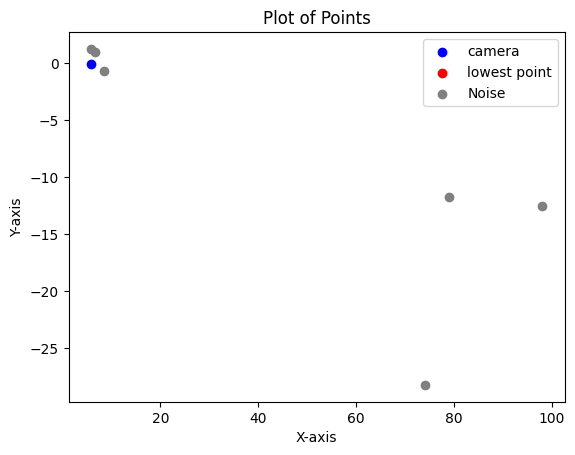

{'associated': [], 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-09-381.png: 416x640 1 car, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


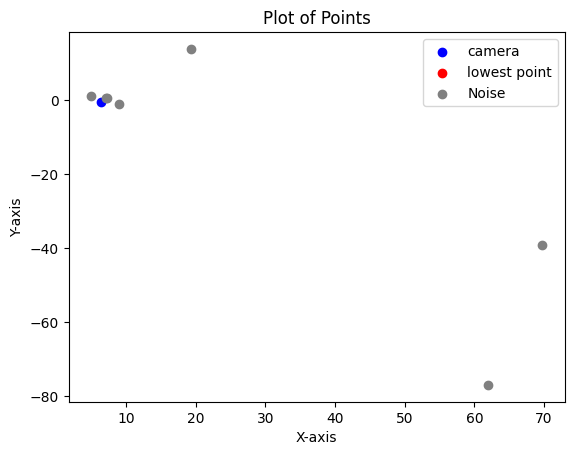

{'associated': [], 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-09-481.png: 416x640 1 car, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


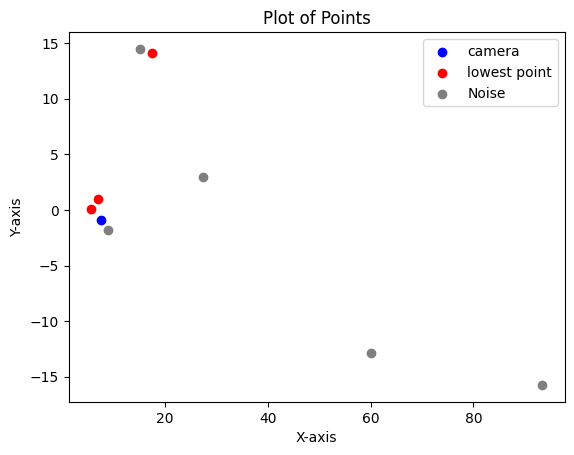

array([[          1],
       [          1],
       [          0]])
{'associated': [],
 'non_associated': {'Radar': [[[879.7148884555584, 780.8988539278336],
                               [954.4876721240312, 774.7601630337981],
                               [7.880435943603516]],
                              [[880.2695055832838, 573.7384397389977],
                               [802.8424853495502, 646.7453509849764],
                               [8.324398040771484]],
                              [[-156.13553701516116, 250.08947290430174],
                               [-195.72372284256306, 218.39485924013627],
                               [0.09964074939489365]]],
                    'YOLO': [array([          3,      811.27,      459.68,      1292.2,      792.34,     0.95464], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-09-581.png: 416x640 1 car, 64.0ms
Speed: 4.0ms 

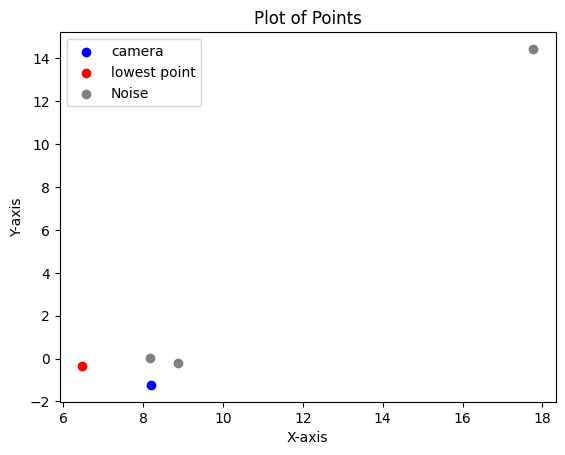

array([[          1]])
{'associated': [[array([          3,      872.57,      443.68,      1314.6,      745.37,     0.95264], dtype=float32),
                 [[1010.118839592714, 735.922431395801],
                  [1041.182708381981, 723.8864907611032],
                  [8.37312126159668]]]],
 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-09-614.png: 416x640 1 car, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


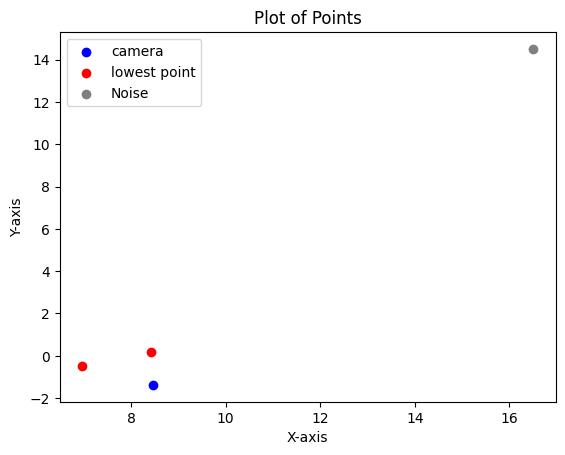

array([[          1],
       [          1]])
{'associated': [],
 'non_associated': {'Radar': [[[994.7541457581589, 638.3435215462923],
                               [1052.239914631706, 694.556107091724],
                               [8.611858367919922]],
                              [[983.6446691304521, 526.9237181711003],
                               [938.9574178840847, 578.7846926448807],
                               [8.782578468322754]]],
                    'YOLO': [array([          3,      900.93,      436.24,      1324.7,      727.88,     0.95564], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-09-681.png: 416x640 1 car, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


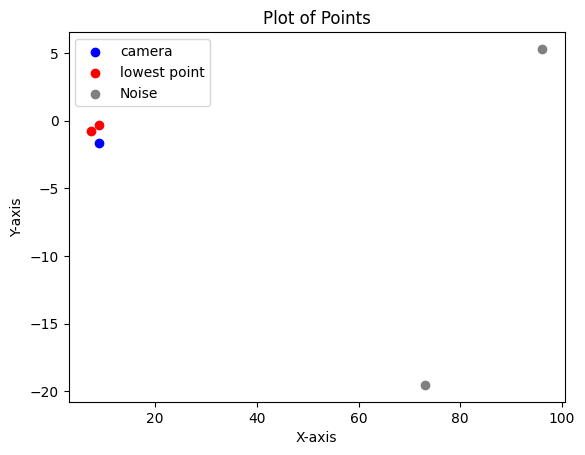

array([[          1],
       [          1]])
{'associated': [],
 'non_associated': {'Radar': [[[1025.4849203290078, 669.5780022226729],
                               [1097.8496727921067, 653.179292213892],
                               [8.639132499694824]],
                              [[1112.3526675722214, 503.9987807412867],
                               [1010.2642924065743, 501.7003820733659],
                               [9.166167259216309]]],
                    'YOLO': [array([          3,      950.97,      420.24,      1339.5,      692.05,     0.95229], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-09-714.png: 416x640 1 car, 65.0ms
Speed: 4.0ms preprocess, 65.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


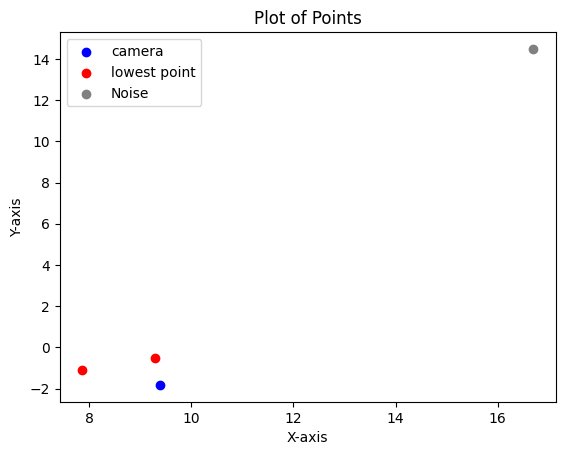

array([[          1],
       [          1]])
{'associated': [],
 'non_associated': {'Radar': [[[1068.9928890739093, 600.5945139414197],
                               [1136.2681962800505, 645.9205891394131],
                               [8.885688781738281]],
                              [[1022.9903962131584, 513.5804536465663],
                               [1034.32592686288, 550.2094643360876],
                               [8.948320388793945]]],
                    'YOLO': [array([          3,      974.04,      414.19,      1347.9,       675.1,      0.9564], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-09-781.png: 416x640 1 car, 65.0ms
Speed: 4.0ms preprocess, 65.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


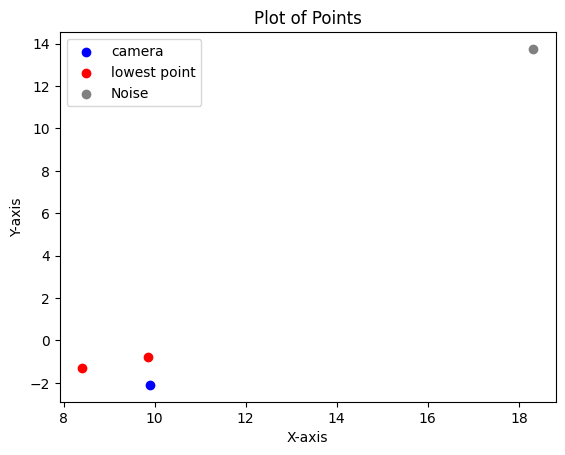

array([[          1],
       [          1]])
{'associated': [],
 'non_associated': {'Radar': [[[1078.782370037463, 572.8360643979797],
                               [1153.4378723943744, 617.6380090944372],
                               [8.964664459228516]],
                              [[1153.2769623561228, 476.4477975749012],
                               [1065.0724932008984, 468.6600056969099],
                               [9.26598834991455]]],
                    'YOLO': [array([          3,      1014.2,      403.77,      1361.4,      649.67,     0.95358], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-09-814.png: 416x640 1 car, 65.0ms
Speed: 4.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


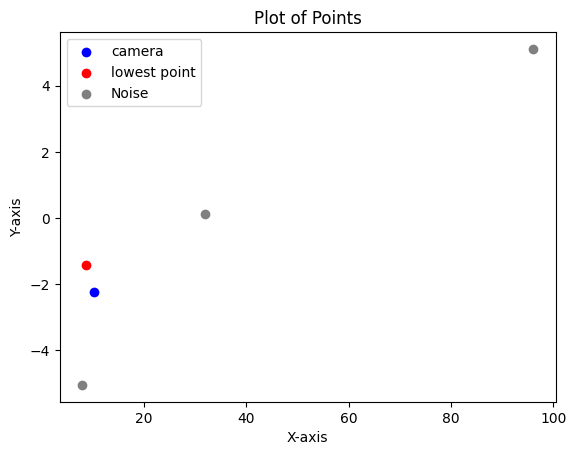

array([[          1]])
{'associated': [[array([          3,      1033.6,      400.33,      1367.9,      638.51,     0.95641], dtype=float32),
                 [[1130.0205168166965, 504.4477744372147],
                  [1169.653932228277, 601.1604043503642],
                  [9.149776458740234]]]],
 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-09-881.png: 416x640 1 car, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


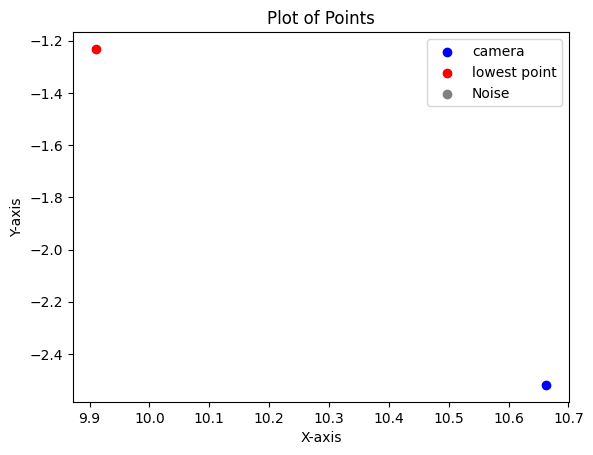

array([[          1]])
{'associated': [[array([          3,      1068.3,      389.59,      1380.1,       616.8,     0.96117], dtype=float32),
                 [[1179.0911871444434, 467.044658397848],
                  [1121.0359886027236, 472.34157364841633],
                  [9.261811256408691]]]],
 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-09-914.png: 416x640 1 car, 64.0ms
Speed: 3.0ms preprocess, 64.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


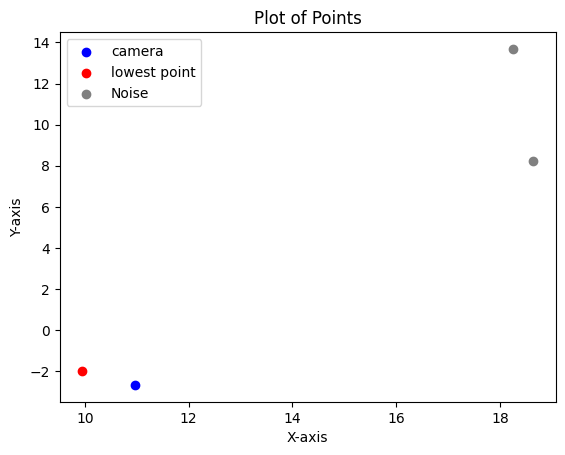

array([[          1]])
{'associated': [[array([          3,      1083.2,      384.62,      1385.9,      604.95,     0.95815], dtype=float32),
                 [[1237.2936210524272, 460.57149506527617],
                  [1218.6761260685619, 490.5906552304304],
                  [9.390746116638184]]]],
 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-09-981.png: 416x640 1 car, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


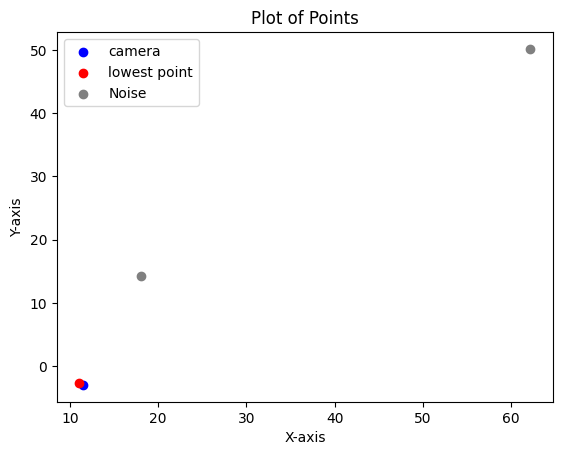

array([[          1]])
{'associated': [[array([          3,      1113.7,      376.91,      1398.7,      585.24,     0.95644], dtype=float32),
                 [[1188.2051224426286, 427.5540036029731],
                  [1267.7643134635928, 441.9654007728824],
                  [9.292275428771973]]]],
 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-10-081.png: 416x640 1 car, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


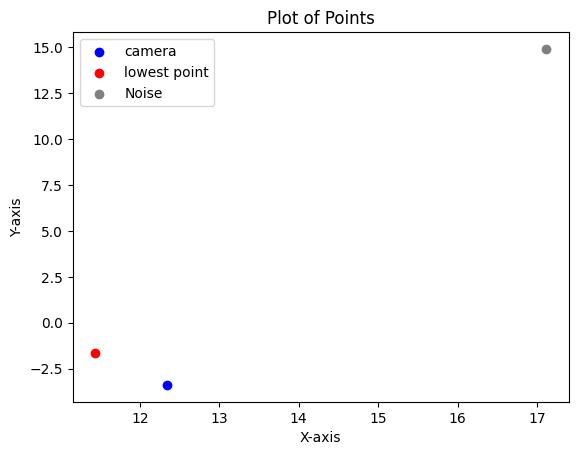

array([[          1]])
{'associated': [[array([          3,      1150.4,      365.72,      1413.5,      558.78,     0.94825], dtype=float32),
                 [[1225.3379027932338, 448.737977638194],
                  [1141.558092886874, 508.5814549357311],
                  [9.22827434539795]]]],
 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-10-114.png: 416x640 1 car, 64.0ms
Speed: 4.0ms preprocess, 64.0ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


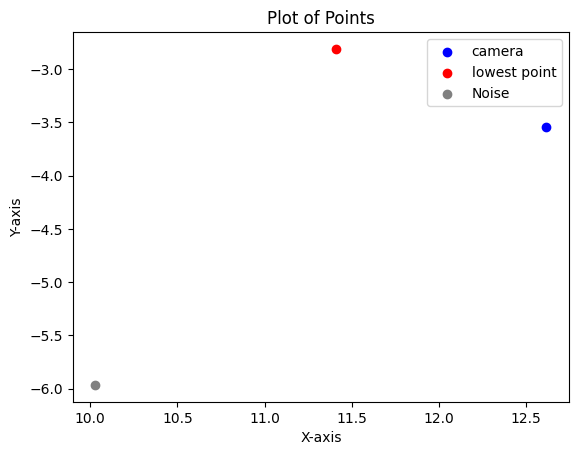

array([[          1]])
{'associated': [[array([          3,      1163.5,      363.03,      1418.7,      550.87,     0.94738], dtype=float32),
                 [[1270.17218478904, 439.9609510669933],
                  [1273.5252405663375, 504.17154466090994],
                  [9.343708992004395]]]],
 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-10-181.png: 416x640 1 car, 65.0ms
Speed: 2.0ms preprocess, 65.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


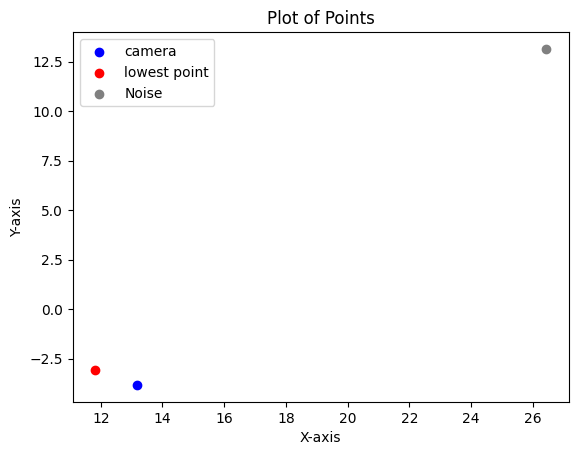

array([[          1]])
{'associated': [[array([          3,      1183.9,      356.83,      1427.5,      535.25,     0.95108], dtype=float32),
                 [[1271.1362707990759, 431.6888467257179],
                  [1290.833587034746, 498.37854073404617],
                  [9.311132431030273]]]],
 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-10-281.png: 416x640 1 car, 65.0ms
Speed: 5.0ms preprocess, 65.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


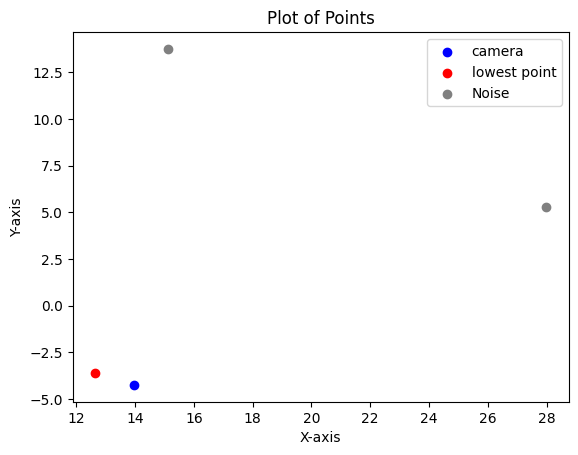

array([[          1]])
{'associated': [[array([          3,      1214.5,      347.83,      1438.2,      516.04,     0.94919], dtype=float32),
                 [[1307.897970554412, 431.7361651973857],
                  [1322.184760131948, 482.23446803169907],
                  [9.298259735107422]]]],
 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-10-381.png: 416x640 1 car, 75.0ms
Speed: 2.0ms preprocess, 75.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


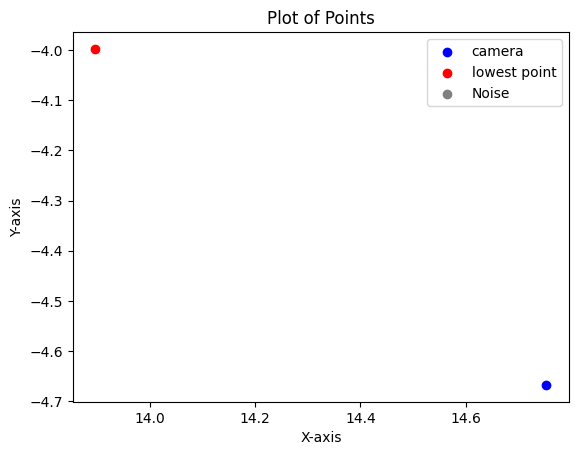

array([[          1]])
{'associated': [[array([          3,      1239.7,      340.72,      1449.9,      498.84,     0.95649], dtype=float32),
                 [[1307.3933214660256, 395.4426279250375],
                  [1348.40585208302, 202.61387985986775],
                  [9.225067138671875]]]],
 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-10-414.png: 416x640 1 car, 76.0ms
Speed: 4.0ms preprocess, 76.0ms inference, 5.0ms postprocess per image at shape (1, 3, 416, 640)


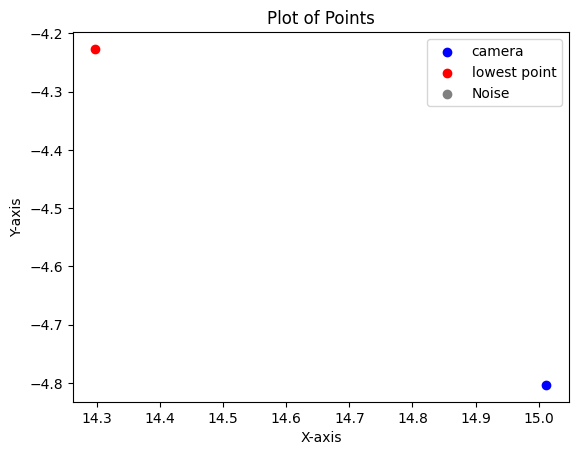

array([[          1]])
{'associated': [[array([          3,      1247.1,      339.23,      1453.2,      493.54,     0.94968], dtype=float32),
                 [[1354.272830133352, 420.93489013071763],
                  [1343.4683512366773, 394.1028861058194],
                  [9.278621673583984]]]],
 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-10-481.png: 416x640 1 car, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


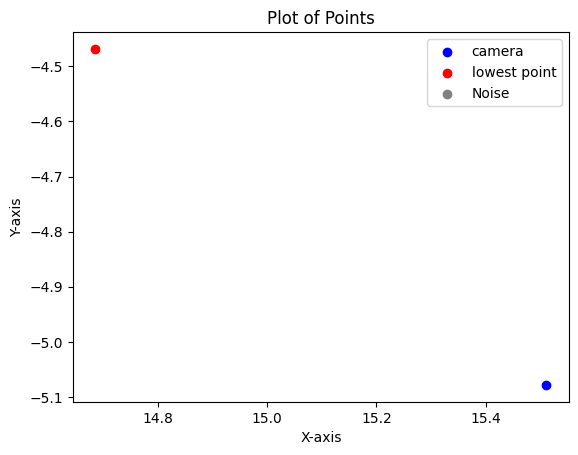

array([[          1]])
{'associated': [[array([          3,      1263.1,      333.67,      1459.2,      483.83,     0.95628], dtype=float32),
                 [[1324.833142628367, 355.8379160252922],
                  [1372.7048628232112, 177.46578160149167],
                  [9.2024564743042]]]],
 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-10-581.png: 416x640 1 car, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


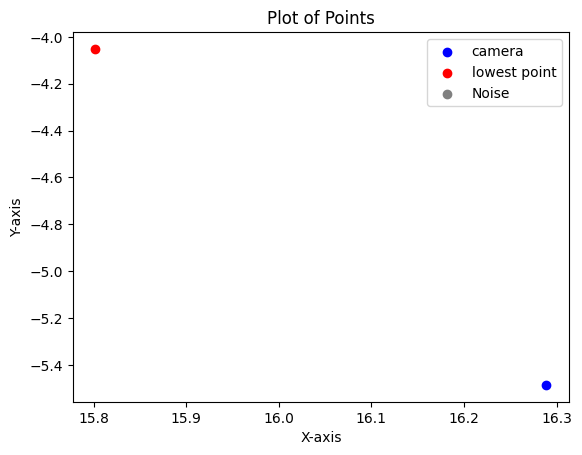

array([[          1]])
{'associated': [[array([          3,      1282.5,       328.3,        1468,      469.92,     0.94665], dtype=float32),
                 [[1365.8051521059795, 400.2470117577164],
                  [1286.2542080165042, 461.084407562521],
                  [9.113197326660156]]]],
 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-10-681.png: 416x640 1 car, 68.0ms
Speed: 4.0ms preprocess, 68.0ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


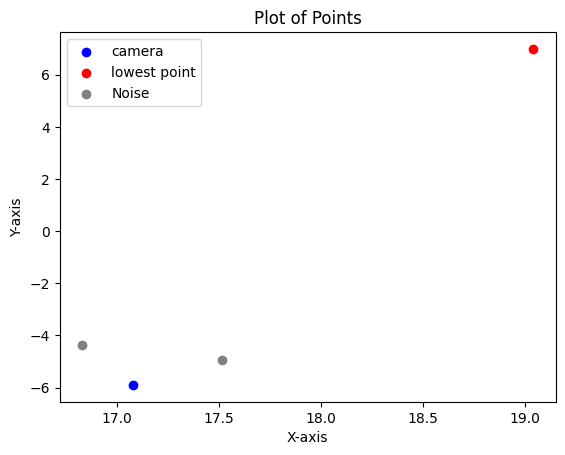

array([[          0]])
{'associated': [],
 'non_associated': {'Radar': [[[-3.300436140956892, 205.78695114558474],
                               [416.409503795788, 74.52396321388746],
                               [-0.10001185536384583]]],
                    'YOLO': [array([          3,      1299.4,      323.26,      1477.2,      457.04,     0.94673], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-10-714.png: 416x640 1 car, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


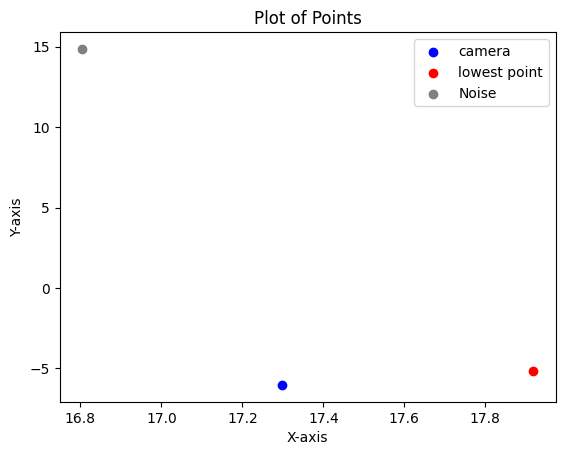

array([[          1]])
{'associated': [[array([          3,      1305.7,      321.94,      1479.1,      453.74,       0.951], dtype=float32),
                 [[1379.7653675377994, 393.4887185904385],
                  [1337.2380443889206, 334.1815469161078],
                  [9.149032592773438]]]],
 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-10-781.png: 416x640 1 car, 67.0ms
Speed: 2.0ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


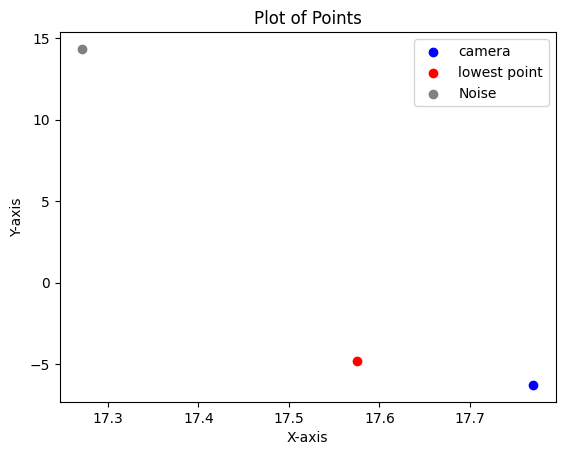

array([[          1]])
{'associated': [[array([          3,      1316.1,      318.79,      1484.1,      446.78,     0.93693], dtype=float32),
                 [[1367.0696986180792, 396.0525109444315],
                  [1312.830715192803, 420.62478856022585],
                  [9.018638610839844]]]],
 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-10-881.png: 416x640 1 car, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


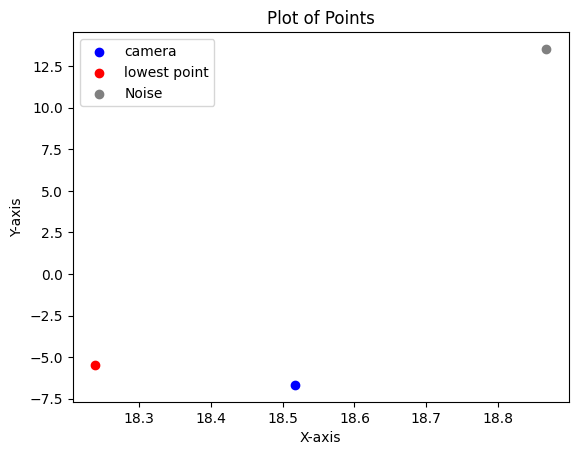

array([[          0]])
{'associated': [],
 'non_associated': {'Radar': [[[1394.0638420564198, 294.70218755313493],
                               [1346.5770025849936, 428.80903110562383],
                               [8.97148609161377]]],
                    'YOLO': [array([          3,      1331.4,      315.82,      1489.3,      436.52,     0.93186], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-10-981.png: 416x640 1 car, 67.0ms
Speed: 4.0ms preprocess, 67.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


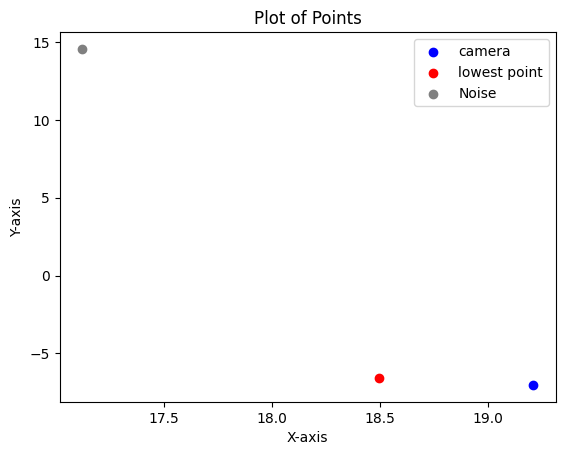

array([[          1]])
{'associated': [[array([          3,      1343.3,      310.31,      1495.1,      427.72,     0.92954], dtype=float32),
                 [[1406.9385147129808, 360.4152620394912],
                  [1422.909186800799, 385.34099149197294],
                  [8.929643630981445]]]],
 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-11-014.png: 416x640 1 car, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


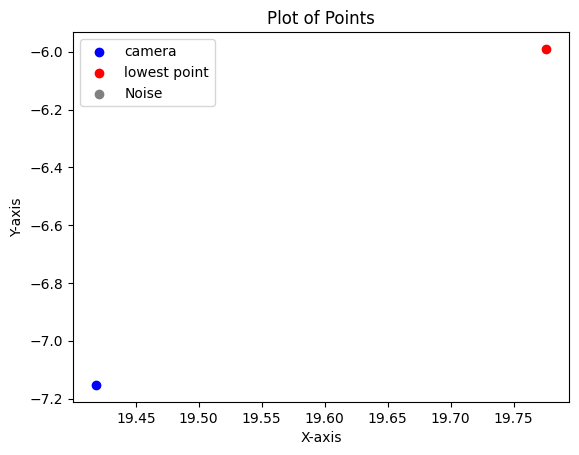

array([[          1]])
{'associated': [[array([          3,      1347.9,      309.03,        1497,      425.21,     0.92969], dtype=float32),
                 [[1406.7366759276983, 358.8539030725564],
                  [1348.7903557763004, 419.50584340658696],
                  [8.912992477416992]]]],
 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-11-081.png: 416x640 1 car, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


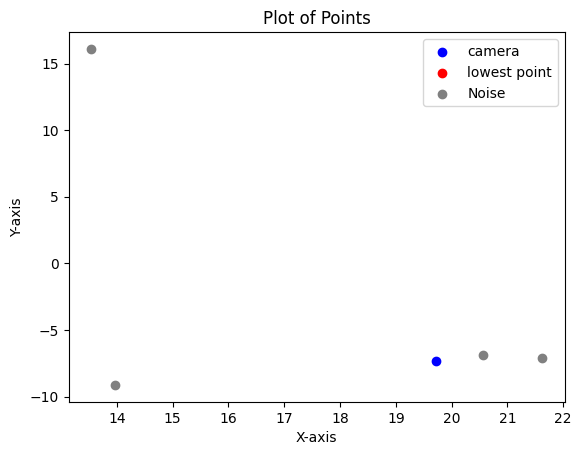

{'associated': [], 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-11-114.png: 416x640 1 car, 67.0ms
Speed: 4.0ms preprocess, 67.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


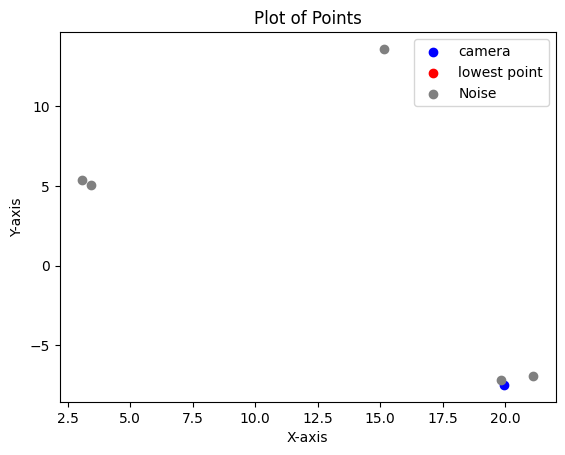

{'associated': [], 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-11-181.png: 416x640 2 cars, 65.0ms
Speed: 4.0ms preprocess, 65.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


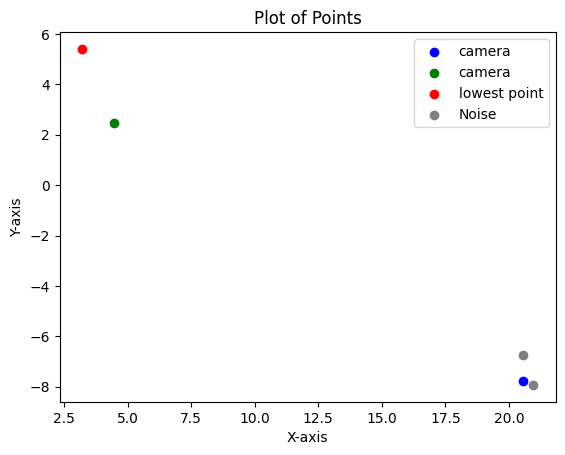

array([[          0,           0]])
{'associated': [],
 'non_associated': {'Radar': [[[-708.2592506796783, 1052.4928363146278],
                               [-828.5865232898656, 1020.6648822391633],
                               [-0.12583522498607635]]],
                    'YOLO': [array([          3,      1367.4,      301.77,      1506.2,      412.27,     0.91367], dtype=float32),
                             array([          3,   0.0052414,      658.53,      192.59,      1205.3,      0.3888], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-11-281.png: 416x640 2 cars, 65.0ms
Speed: 4.0ms preprocess, 65.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


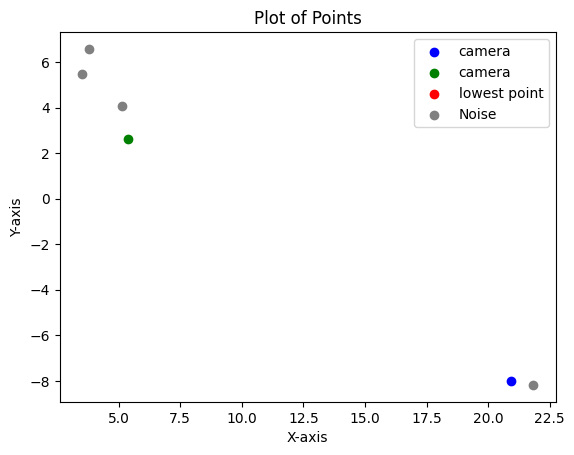

{'associated': [], 'non_associated': {'Radar': [], 'YOLO': []}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-11-381.png: 416x640 2 cars, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


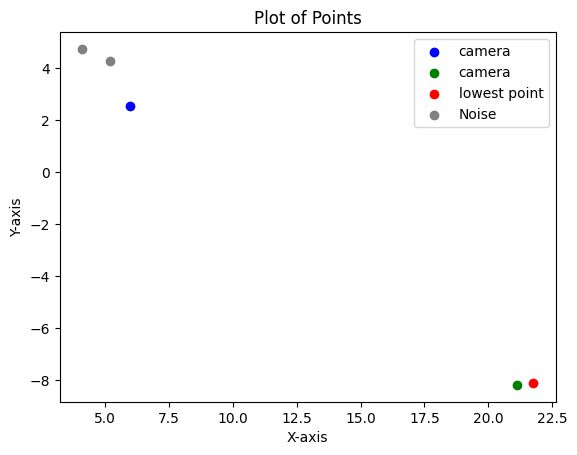

array([[          0,           0]])
{'associated': [],
 'non_associated': {'Radar': [[[1454.53363210217, 273.8260802119664],
                               [1479.656201105941, 46.11961338036283],
                               [8.664905548095703]]],
                    'YOLO': [array([          3,           0,      522.87,      597.11,      950.08,     0.95458], dtype=float32),
                             array([          3,        1386,       295.1,      1515.7,      406.56,     0.90194], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-11-414.png: 416x640 2 cars, 65.0ms
Speed: 4.0ms preprocess, 65.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


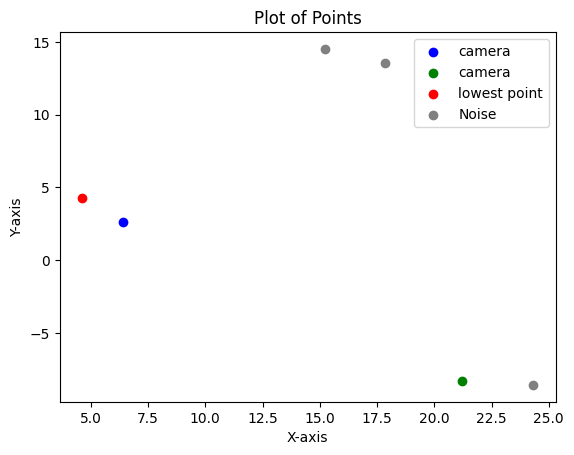

array([[          1,           0]])
{'associated': [[array([          3,           0,      493.36,      651.43,       897.8,     0.95275], dtype=float32),
                 [[92.43668200852917, 798.3501952715511],
                  [-76.62715129827087, 898.4099663968776],
                  [5.700590133666992]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,      1388.9,      293.45,      1517.5,      405.33,     0.90147], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-11-481.png: 416x640 2 cars, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


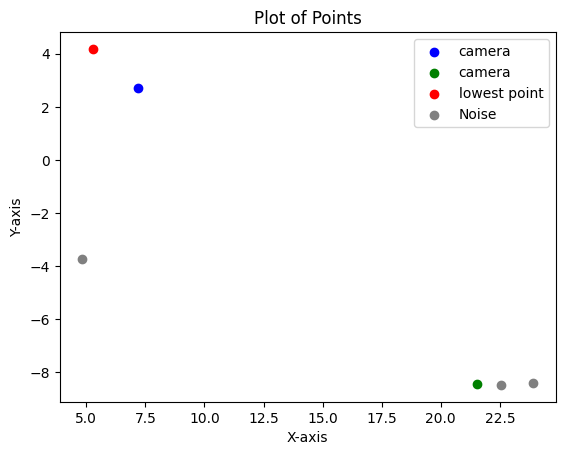

array([[          1,           0]])
{'associated': [[array([          3,      30.982,      466.38,      733.08,      822.41,     0.95723], dtype=float32),
                 [[120.55560617572003, 700.042464424175],
                  [39.55421399595034, 790.039566323002],
                  [6.50540828704834]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,      1394.5,      290.48,      1520.1,      402.45,     0.89564], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-11-581.png: 416x640 2 cars, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


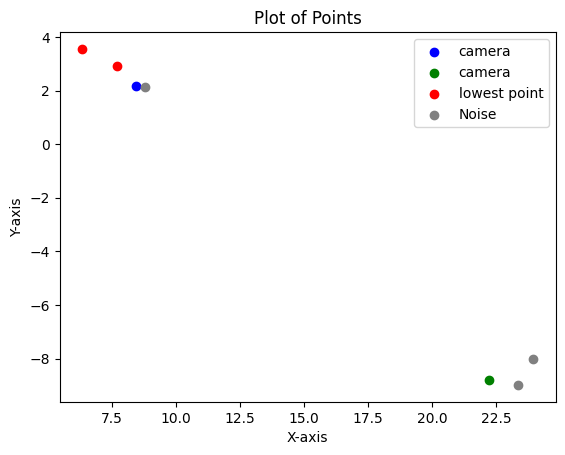

array([[          0,           0],
       [          1,           0]])
{'associated': [[array([          3,      271.81,      436.75,      838.63,      726.63,     0.95558], dtype=float32),
                 [[291.35573212241843, 578.60581247997],
                  [486.2334559794433, 562.8868018087967],
                  [8.334718704223633]]]],
 'non_associated': {'Radar': [[[307.58148701883255, 730.4854196153628],
                               [298.16348166948853, 744.2779017496291],
                               [7.801225185394287]]],
                    'YOLO': [array([          3,      1401.7,      286.99,      1523.7,      395.65,      0.8987], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-11-614.png: 416x640 2 cars, 65.0ms
Speed: 4.0ms preprocess, 65.0ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


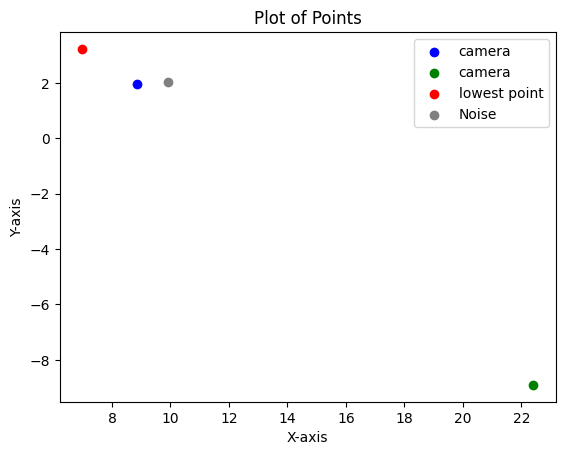

array([[          1,           0]])
{'associated': [[array([          3,      329.67,      424.84,      872.76,      703.79,     0.95189], dtype=float32),
                 [[383.73490921226, 462.93978868495293],
                  [401.6443153850557, 669.3535115662369],
                  [8.97736644744873]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,      1404.6,      285.83,      1525.1,      394.15,     0.90412], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-11-681.png: 416x640 3 cars, 66.0ms
Speed: 3.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


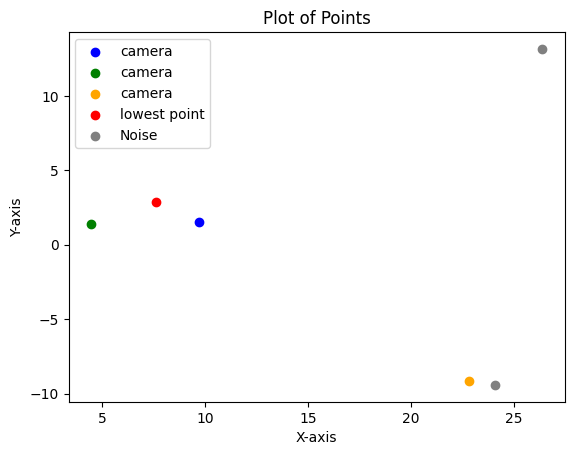

array([[          1,           0,           0]])
{'associated': [[array([          3,      444.58,      404.75,      933.84,      659.08,     0.95343], dtype=float32),
                 [[535.6311481331627, 587.290460990672],
                  [497.59210428244137, 611.246045037572],
                  [10.095008850097656]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,           0,      773.25,      840.03,      1209.9,     0.94216], dtype=float32),
                             array([          3,        1410,       285.1,      1526.8,       390.7,      0.9002], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-11-781.png: 416x640 3 cars, 65.0ms
Speed: 3.0ms preprocess, 65.0ms inference, 3.0ms postprocess per image at shape (1, 3, 416, 640)


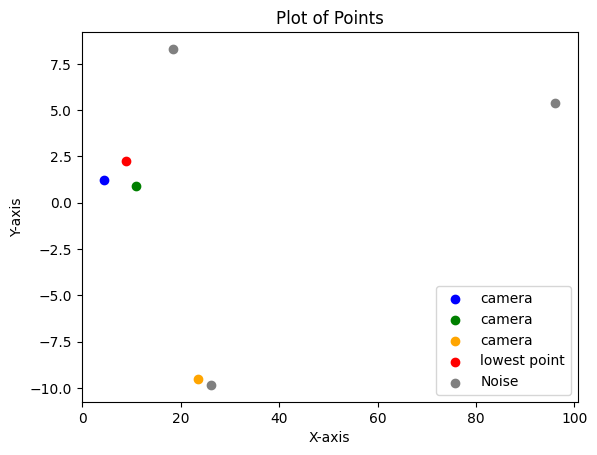

array([[          0,           1,           0]])
{'associated': [[array([          3,      590.03,      375.81,      1009.8,      606.16,     0.94453], dtype=float32),
                 [[666.3788720465161, 517.9148112492725],
                  [646.3307914285434, 560.8308449914326],
                  [11.262923240661621]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,           0,      701.45,      935.11,      1210.9,     0.94661], dtype=float32),
                             array([          3,      1417.7,      283.42,      1530.1,      384.27,     0.89546], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-11-881.png: 416x640 3 cars, 68.0ms
Speed: 3.0ms preprocess, 68.0ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 640)


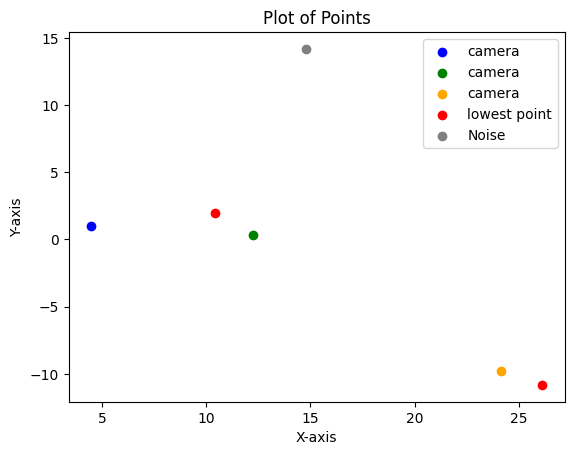

array([[          0,           1,           0],
       [          0,           0,           0]])
{'associated': [[array([          3,      703.13,      355.26,      1056.9,      562.81,     0.94436], dtype=float32),
                 [[778.3759617965263, 485.2137136837497],
                  [711.2919458314533, 517.7451213202584],
                  [6.090671539306641]]]],
 'non_associated': {'Radar': [[[1484.4843234933614, 274.7979226443747],
                               [1547.406594905355, -47.15869104334076],
                               [8.320456504821777]]],
                    'YOLO': [array([          3,      78.594,      652.76,      1001.2,      1211.7,     0.94551], dtype=float32),
                             array([          3,      1423.1,       281.4,      1533.4,      379.57,     0.89607], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-11-914.png: 416x640 3 ca

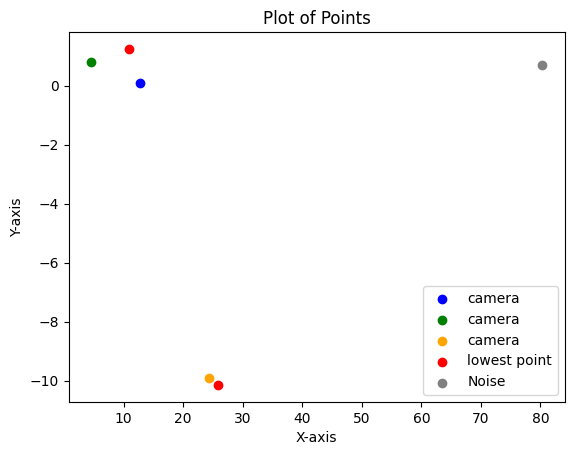

array([[          1,           0,           0],
       [          0,           0,           0]])
{'associated': [[array([          3,      733.45,      351.92,      1073.3,      548.64,     0.95139], dtype=float32),
                 [[919.2693613908385, 476.538030291554],
                  [810.041969329735, 490.2246501338049],
                  [12.93773365020752]]]],
 'non_associated': {'Radar': [[[1476.7166694109965, 240.9857509156026],
                               [1509.0883322601617, -0.33478978486119415],
                               [8.281667709350586]]],
                    'YOLO': [array([          3,      159.18,      636.51,      1025.2,      1199.9,      0.9458], dtype=float32),
                             array([          3,      1424.8,      280.86,      1534.7,       378.1,     0.89318], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-11-981.png: 416x640 3 c

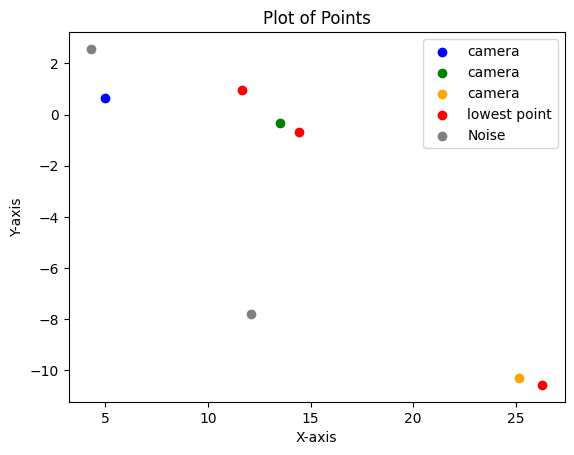

array([[          0,           1,           0],
       [          0,           1,           0],
       [          0,           0,           1]])
{'associated': [[array([          3,      1430.3,      278.61,      1536.2,       372.3,     0.90156], dtype=float32),
                 [[1470.4179595585308, 321.89173640302914],
                  [1489.7837417277924, 315.08416397815535],
                  [8.25500202178955]]]],
 'non_associated': {'Radar': [[[815.0919200629944, 469.5183978167765],
                               [848.0677234592953, 474.6945047688857],
                               [12.373772621154785]],
                              [[1019.4008770106029, 482.5019377132779],
                               [1014.9235835429428, 485.6355871985719],
                               [13.433661460876465]]],
                    'YOLO': [array([          3,      290.31,      605.78,      1063.5,      1111.8,     0.95786], dtype=float32),
                             array([          3, 

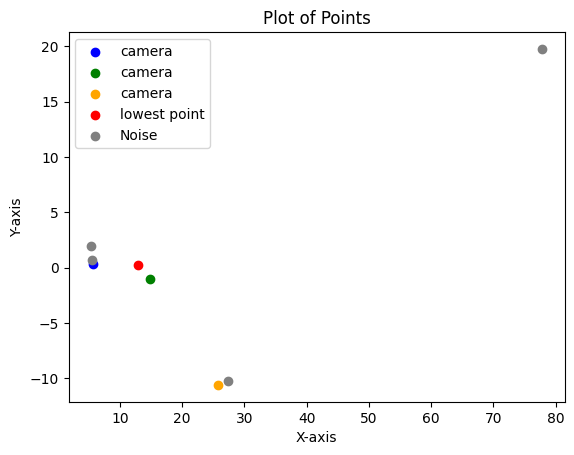

array([[          0,           1,           0]])
{'associated': [[array([          3,      872.47,      334.14,      1146.4,       498.2,     0.94867], dtype=float32),
                 [[955.0853517489587, 411.89265232701337],
                  [927.7040769442787, 454.2776103376589],
                  [13.133675575256348]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,      453.08,      567.28,      1114.4,        1000,     0.95752], dtype=float32),
                             array([          3,      1435.5,      277.11,      1538.8,      367.94,     0.90035], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-12-181.png: 416x640 3 cars, 66.0ms
Speed: 2.0ms preprocess, 66.0ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


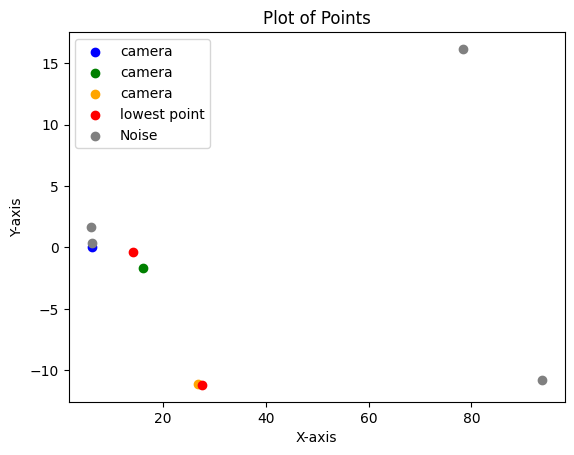

array([[          0,           1,           0],
       [          0,           0,           0]])
{'associated': [[array([          3,      935.86,      325.44,      1182.5,      473.72,     0.94665], dtype=float32),
                 [[1066.3412958787208, 451.848884947909],
                  [989.4105630181947, 431.9915215668521],
                  [12.594513893127441]]]],
 'non_associated': {'Radar': [[[1476.874685857365, 228.6053655328645],
                               [1530.0752695360834, -21.255389003761298],
                               [8.110722541809082]]],
                    'YOLO': [array([          3,      583.46,      530.65,      1156.9,      914.54,     0.95581], dtype=float32),
                             array([          3,      1441.1,      276.21,      1539.5,      360.85,     0.90035], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-12-215.png: 416x640 3 

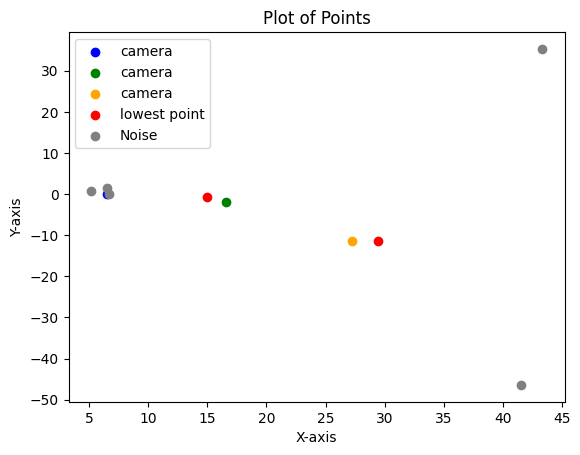

array([[          0,           1,           0],
       [          0,           0,           1]])
{'associated': [[array([          3,      953.92,      322.75,      1192.5,      466.26,     0.94431], dtype=float32),
                 [[1020.3359476113278, 447.4457290429923],
                  [1023.3991192329418, 423.6226204037272],
                  [13.436965942382812]]],
                [array([          3,      1443.1,      276.05,      1540.5,      358.49,     0.89945], dtype=float32),
                 [[1475.82825642571, 297.9256496661151],
                  [1471.031513605334, 271.5880872681413],
                  [8.09230899810791]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,      620.25,      519.43,      1170.4,      888.65,     0.95538], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-12-381.png: 416x640 3 cars, 72.0ms
Speed: 3

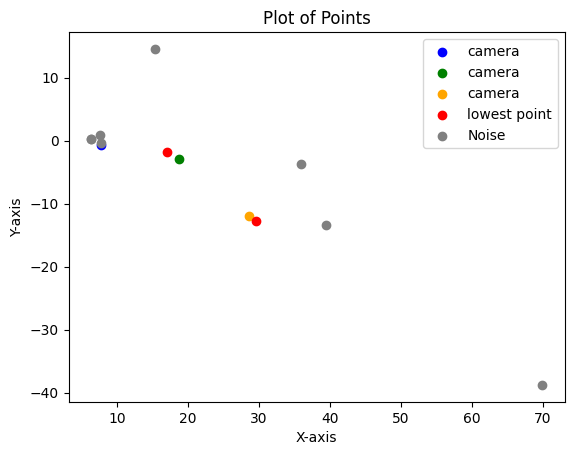

array([[          0,           1,           0],
       [          0,           0,           1]])
{'associated': [[array([          3,      1039.9,      310.97,      1237.2,      435.68,     0.94114], dtype=float32),
                 [[1098.2884584005155, 384.7500479263517],
                  [1088.0583677351967, 410.0765589017193],
                  [13.839958190917969]]],
                [array([          3,      1449.6,      273.72,      1544.4,      351.05,       0.906], dtype=float32),
                 [[1493.4387194519074, 297.9031980603053],
                  [1522.5120865553406, 359.9084997781205],
                  [7.999815464019775]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,      778.03,      482.35,      1226.8,      785.49,      0.9556], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-12-481.png: 416x640 3 cars, 67.0ms
Spee

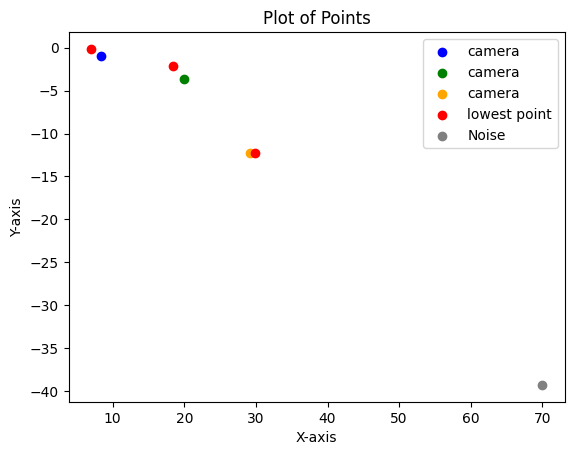

array([[          1,           0,           0],
       [          0,           1,           0],
       [          0,           0,           1]])
{'associated': [[array([          3,      851.58,      461.17,      1256.3,      737.31,     0.95363], dtype=float32),
                 [[956.7496195820863, 654.0841961361219],
                  [995.2953942457987, 654.9791557079832],
                  [6.790680885314941]]],
                [array([          3,      1079.6,      301.45,      1260.6,      420.73,     0.94215], dtype=float32),
                 [[1128.5276412650855, 377.75289596434686],
                  [1098.839849499212, 397.19268590596283],
                  [13.98503303527832]]],
                [array([          3,      1453.6,      272.22,      1546.8,       347.5,      0.9045], dtype=float32),
                 [[1493.4010547714743, 312.5970114295716],
                  [1501.3224498004276, 324.74580252212814],
                  [7.896671295166016]]]],
 'non_associated': {

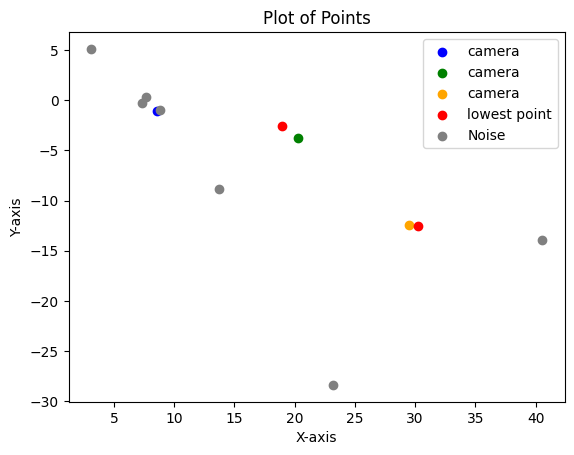

array([[          0,           1,           0],
       [          0,           0,           1]])
{'associated': [[array([          3,      1093.5,      300.11,      1267.4,      416.49,     0.93708], dtype=float32),
                 [[1181.064175312126, 353.22162483420635],
                  [1129.09594306948, 403.4358171698476],
                  [14.13518238067627]]],
                [array([          3,      1454.7,      271.82,      1547.8,      345.78,     0.90393], dtype=float32),
                 [[1506.9975125123956, 300.53956990956135],
                  [1503.7843941943624, 331.9989644067949],
                  [7.885113716125488]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,      871.77,      455.06,      1265.6,      721.67,     0.95724], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-12-581.png: 416x640 3 cars, 66.0ms
Speed:

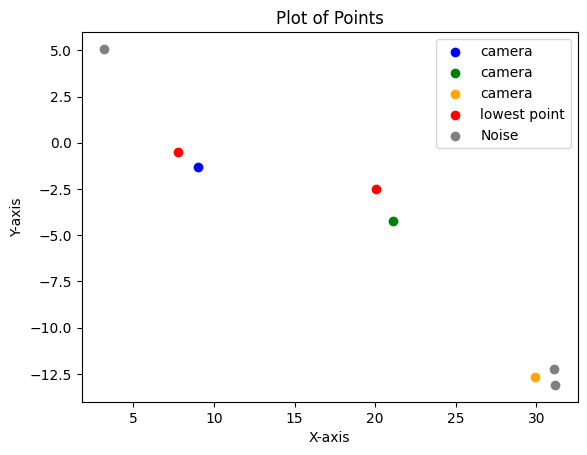

array([[          1,           0,           0],
       [          0,           0,           0]])
{'associated': [[array([          3,      912.25,      446.38,      1281.8,      695.16,     0.95409], dtype=float32),
                 [[957.6638649299224, 650.5706802963598],
                  [1047.4294387279076, 630.5746235354857],
                  [6.798065185546875]]]],
 'non_associated': {'Radar': [[[1113.822493911926, 403.1328469974465],
                               [1114.131639299856, 374.6372759424162],
                               [13.834800720214844]]],
                    'YOLO': [array([          3,      1116.7,      295.79,      1281.4,      408.21,     0.93624], dtype=float32),
                             array([          3,      1457.7,      271.11,      1548.8,      343.64,     0.89561], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-12-681.png: 416x640 3 ca

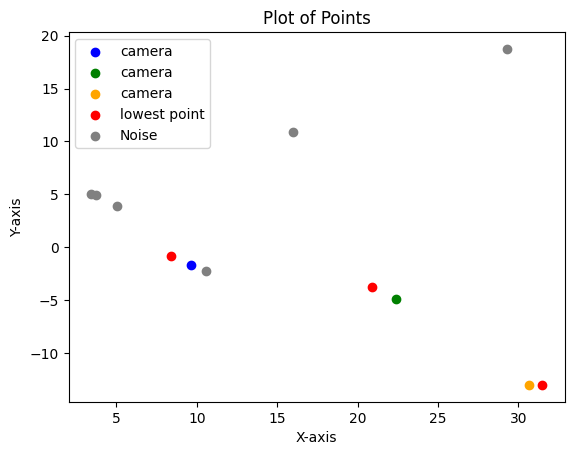

array([[          1,           0,           0],
       [          0,           0,           0],
       [          0,           0,           0]])
{'associated': [[array([          3,      966.25,      432.31,      1303.3,      661.85,      0.9448], dtype=float32),
                 [[996.5689808844978, 588.6126969708538],
                  [1090.4018853753573, 594.3478199031637],
                  [6.964929103851318]]]],
 'non_associated': {'Radar': [[[1222.5587028367681, 249.61260564925564],
                               [1187.851363027664, 381.6517127555811],
                               [14.118793487548828]],
                              [[1559.369195165157, 243.72449690929417],
                               [1540.8411532437774, -21.638468207922593],
                               [6.680727481842041]]],
                    'YOLO': [array([          3,      1147.8,      291.58,      1300.3,      395.45,     0.93604], dtype=float32),
                             array([          3,

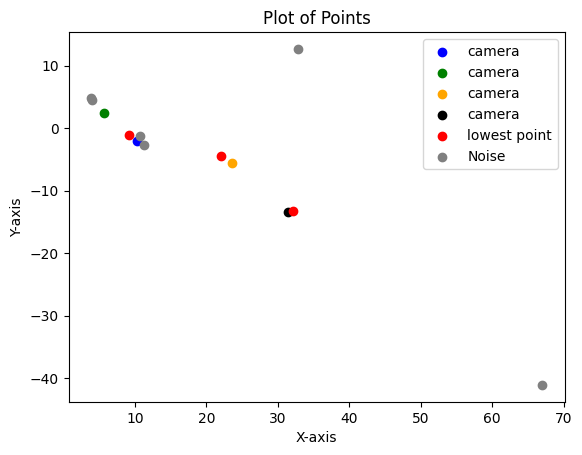

array([[          1,           0,           0,           0],
       [          0,           0,           1,           0],
       [          0,           0,           0,           0]])
{'associated': [[array([          3,      1013.3,      419.53,      1322.9,      632.15,     0.95372], dtype=float32),
                 [[1096.032851031397, 442.4432735243372],
                  [1125.0772014579372, 543.9652627319754],
                  [7.180318355560303]]],
                [array([          3,      1175.1,      285.32,      1317.5,      385.57,      0.9282], dtype=float32),
                 [[1207.8468912427022, 356.0262411478236],
                  [1218.8774238299688, 363.46803317070777],
                  [14.098909378051758]]]],
 'non_associated': {'Radar': [[[1601.3705554513335, 296.93247539645245],
                               [1500.132612131299, 330.3410723489209],
                               [5.1780476570129395]]],
                    'YOLO': [array([          3,           

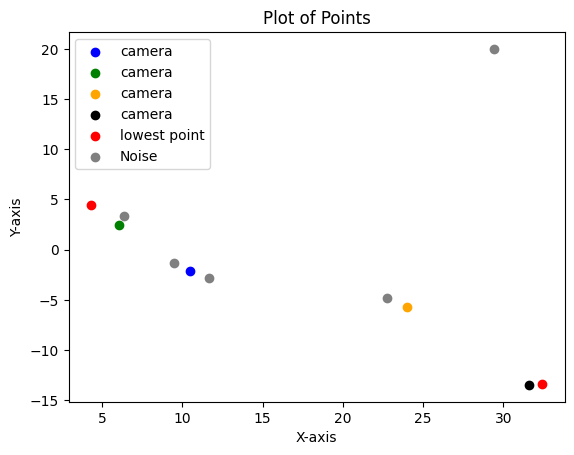

array([[          0,           0,           0,           0],
       [          0,           0,           0,           1]])
{'associated': [[array([          3,      1466.6,      266.77,      1552.6,      335.73,     0.90646], dtype=float32),
                 [[1519.6719862397254, 306.3432230726456],
                  [1502.9395311184394, 338.28548682953885],
                  [7.655249118804932]]]],
 'non_associated': {'Radar': [[[-188.64584054244008, 988.7007101842022],
                               [-188.06352581648474, 941.306003442636],
                               [2.8958775997161865]]],
                    'YOLO': [array([          3,      1028.5,      414.52,        1330,      623.35,     0.96362], dtype=float32),
                             array([          3,           0,      518.01,      670.47,      937.79,     0.94952], dtype=float32),
                             array([          3,      1183.8,      284.98,      1322.9,      382.17,     0.93174], dtype=float32)]}}

i

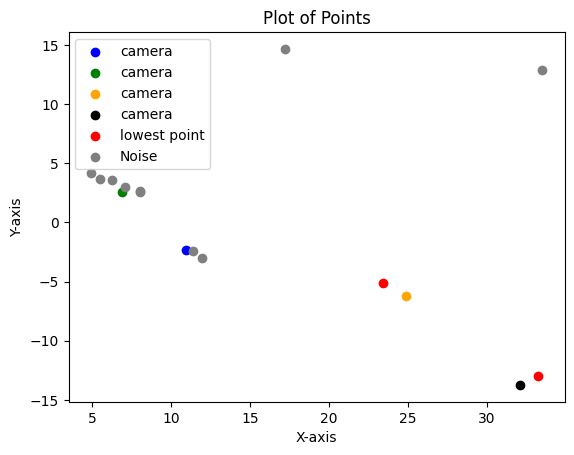

array([[          0,           0,           1,           0],
       [          0,           0,           0,           1]])
{'associated': [[array([          3,        1200,      283.38,      1332.8,      375.53,     0.92882], dtype=float32),
                 [[1225.1066991045134, 358.9069613486273],
                  [1238.7186966744666, 356.3450346336555],
                  [14.154378890991211]]],
                [array([          3,      1469.6,      265.91,      1553.9,       333.6,     0.92724], dtype=float32),
                 [[1512.3117161905805, 299.40087583902846],
                  [1474.7967006796628, 298.0131556680581],
                  [7.611353397369385]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,      1055.9,      409.19,      1340.1,      605.74,      0.9532], dtype=float32),
                             array([          3,      3.3502,      490.39,      763.82,      850.47,     0.94188], dtype=float32)]}}

image 1/1 C:\Dk\Proj

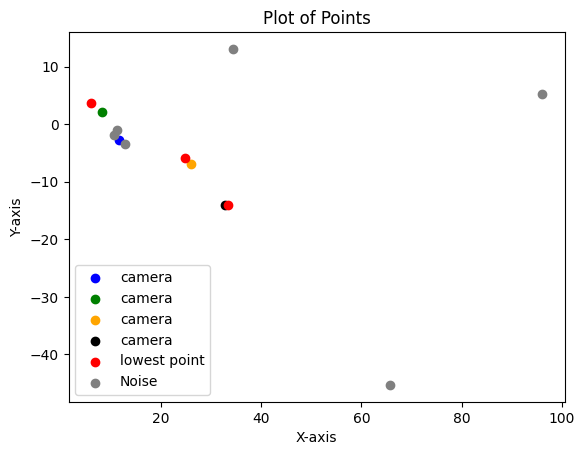

array([[          0,           1,           0,           0],
       [          0,           0,           1,           0],
       [          0,           0,           0,           1]])
{'associated': [[array([          3,      231.71,      464.29,      855.93,         747,     0.94731], dtype=float32),
                 [[296.4205303611399, 722.6586350507074],
                  [247.10888377932383, 736.7170765019208],
                  [7.808251857757568]]],
                [array([          3,      1222.4,      279.25,      1347.7,      367.54,     0.93075], dtype=float32),
                 [[1247.576502289375, 343.32562749384533],
                  [1267.4144543247942, 339.3820216766801],
                  [14.175582885742188]]],
                [array([          3,      1472.7,      265.35,      1554.1,      330.94,     0.90441], dtype=float32),
                 [[1480.2341780084837, 295.2780714955309],
                  [1516.7219665856471, 319.7599251349567],
                  [7.51

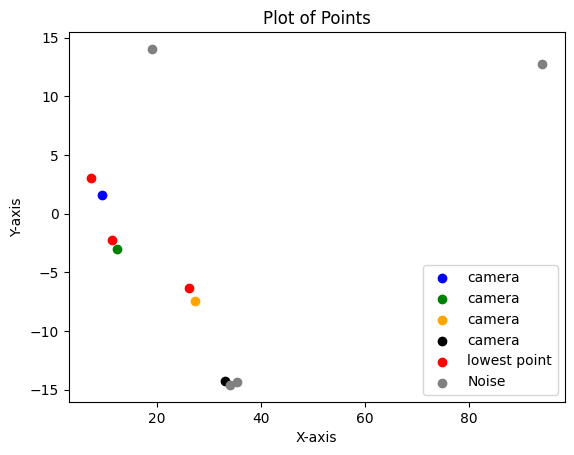

array([[          1,           0,           0,           0],
       [          0,           1,           0,           0],
       [          0,           0,           1,           0]])
{'associated': [[array([          3,      431.61,      435.04,      931.03,      670.96,     0.95731], dtype=float32),
                 [[497.62419830477967, 669.8767723374069],
                  [458.1933571486605, 691.5542670039866],
                  [9.767037391662598]]],
                [array([          3,      1122.7,      388.71,      1369.6,      561.61,     0.94778], dtype=float32),
                 [[1263.3702322982429, 469.64936542785256],
                  [1218.1584797081644, 498.46170971060724],
                  [7.492527008056641]]],
                [array([          3,      1242.9,      276.29,      1360.7,      359.87,     0.93166], dtype=float32),
                 [[1248.4761285502611, 344.7282494477308],
                  [1272.8218160757958, 335.2017573582634],
                  [14.

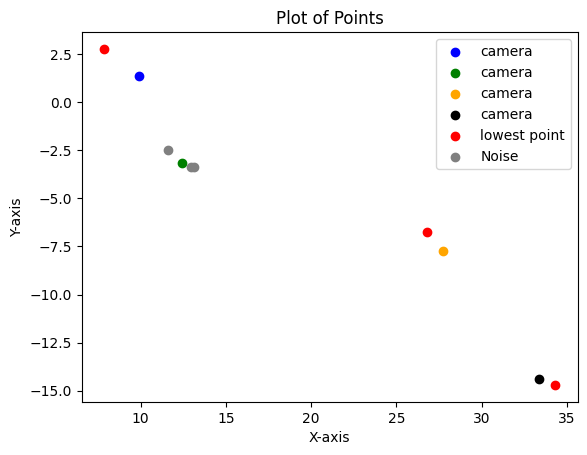

array([[          1,           0,           0,           0],
       [          0,           0,           1,           0],
       [          0,           0,           0,           1]])
{'associated': [[array([          3,         477,      425.71,      957.38,      649.96,     0.94801], dtype=float32),
                 [[603.0908565879447, 607.2925394564136],
                  [529.6641688691194, 642.9282695677427],
                  [10.706005096435547]]],
                [array([          3,      1249.2,      274.88,      1365.6,      356.78,      0.9281], dtype=float32),
                 [[1284.7913302935387, 354.9162022575493],
                  [1284.7547970541334, 353.1282170946406],
                  [14.18694019317627]]],
                [array([          3,      1477.1,      263.87,      1556.2,      328.22,     0.89803], dtype=float32),
                 [[1516.6827065032253, 292.5106927454791],
                  [1523.4811930161734, 329.841538122503],
                  [7.4639

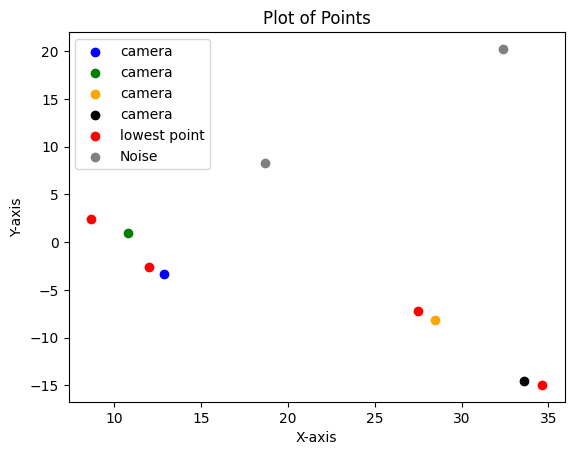

array([[          0,           1,           0,           0],
       [          1,           0,           0,           0],
       [          0,           0,           1,           0],
       [          0,           0,           0,           1]])
{'associated': [[array([          3,      572.61,      406.68,      999.53,      611.89,     0.95019], dtype=float32),
                 [[697.1253638635139, 552.337088726123],
                  [613.539952457, 582.8885551907445],
                  [11.529378890991211]]],
                [array([          3,      1149.5,      380.62,      1382.7,      543.81,     0.95402], dtype=float32),
                 [[1222.053942471957, 469.1308768312982],
                  [1238.0791584608899, 470.3024874402792],
                  [7.399680137634277]]],
                [array([          3,      1260.4,      271.84,      1372.9,      352.59,     0.93405], dtype=float32),
                 [[1282.5683741726818, 338.58990836830446],
                  [1302.504

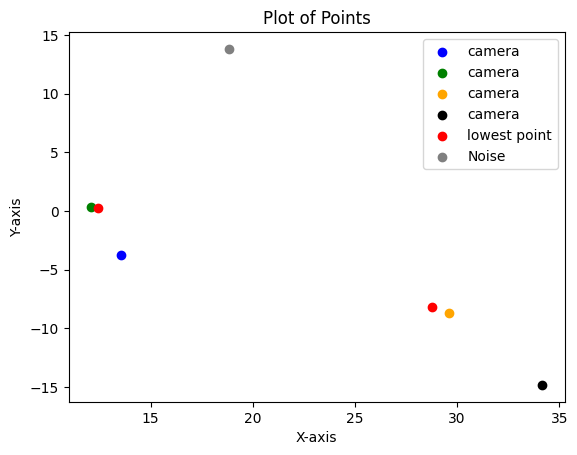

array([[          1,           0,           0,           0],
       [          0,           0,           0,           0]])
{'associated': [[array([          3,      1175.2,      371.35,        1394,      526.63,     0.95078], dtype=float32),
                 [[1187.1611275152288, 450.8351936874432],
                  [929.8592480917337, 460.89697313686247],
                  [8.654108047485352]]]],
 'non_associated': {'Radar': [[[1473.0399182844044, 277.9670776668778],
                               [1328.2396665230071, 319.9882620870995],
                               [9.463698387145996]]],
                    'YOLO': [array([          3,      687.77,      384.77,      1052.8,      567.15,     0.94645], dtype=float32),
                             array([          3,      1276.9,      268.48,      1384.6,      346.53,     0.92748], dtype=float32),
                             array([          3,      1482.1,      262.27,      1559.3,      325.12,     0.88863], dtype=float32)]}}

imag

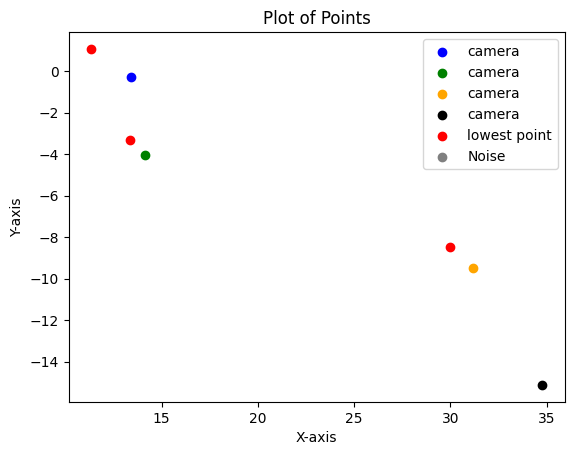

array([[          0,           0,           0,           0],
       [          0,           0,           0,           0],
       [          0,           0,           1,           0]])
{'associated': [[array([          3,      1292.2,      265.39,      1394.9,      338.94,     0.92488], dtype=float32),
                 [[1383.8443851470322, 309.67924395265993],
                  [1328.499683217378, 314.41858613774707],
                  [12.316915512084961]]]],
 'non_associated': {'Radar': [[[763.4250935585935, 504.5474879865061],
                               [833.6305623246379, 485.9211833621253],
                               [12.048018455505371]],
                              [[1151.110593514327, 472.56347970711516],
                               [1277.8441466783486, 446.9580981747568],
                               [7.19155216217041]]],
                    'YOLO': [array([          3,      783.54,      366.77,      1101.6,      530.15,     0.95323], dtype=float32),
           

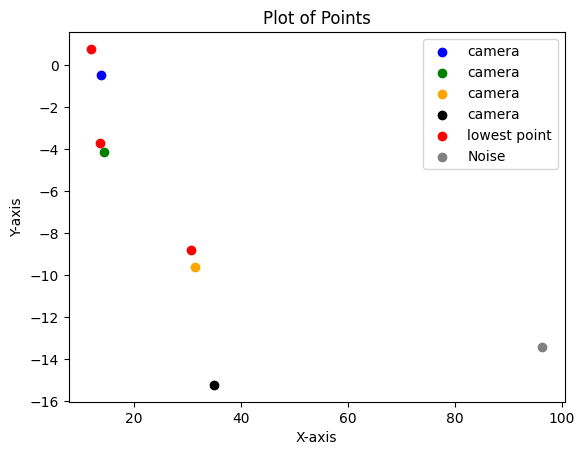

array([[          1,           0,           0,           0],
       [          0,           0,           0,           0],
       [          0,           0,           0,           0]])
{'associated': [[array([          3,      811.88,      361.83,        1117,      519.82,     0.95422], dtype=float32),
                 [[846.8678844284681, 491.83801930415774],
                  [871.1839828342746, 469.36198725640344],
                  [12.512467384338379]]]],
 'non_associated': {'Radar': [[[1201.2812389279688, 439.74478165406],
                               [1304.4919207785676, 479.2006348713969],
                               [8.07905101776123]],
                              [[1470.966868372417, 308.57187632562665],
                               [1333.0593540296643, 310.16395086855545],
                               [10.92781925201416]]],
                    'YOLO': [array([          3,      1203.5,      361.76,      1408.5,      508.45,     0.94753], dtype=float32),
            

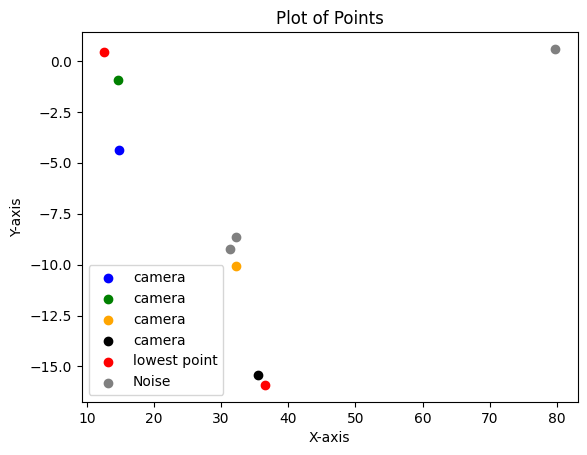

array([[          0,           1,           0,           0],
       [          0,           0,           0,           1]])
{'associated': [[array([          3,      862.85,      351.38,      1143.5,      501.28,     0.95239], dtype=float32),
                 [[1054.436676728869, 448.20931212005576],
                  [908.206045152326, 461.48706658036326],
                  [11.098715782165527]]],
                [array([          3,      1486.7,      259.28,      1561.3,      320.45,     0.88613], dtype=float32),
                 [[1529.651148548565, 282.85174225099854],
                  [1534.0736864674852, 308.8965959819769],
                  [7.282238483428955]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,      1216.3,      357.89,      1414.8,      498.03,     0.95348], dtype=float32),
                             array([          3,      1306.8,      264.11,        1404,      334.12,     0.92981], dtype=float32)]}}

image 1/1 C:\Dk\Projec

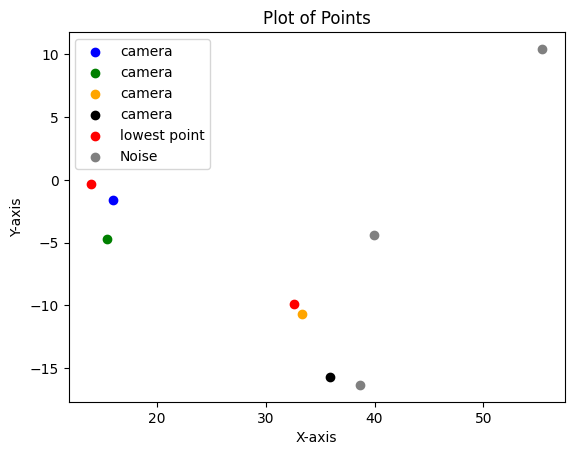

array([[          1,           0,           0,           0],
       [          0,           0,           1,           0]])
{'associated': [[array([          3,      928.06,      340.41,        1179,      476.65,      0.9502], dtype=float32),
                 [[1114.9361510906467, 452.1449304958794],
                  [981.2339000379501, 447.6281276773348],
                  [11.929333686828613]]],
                [array([          3,      1319.6,      261.32,      1413.4,      329.49,     0.92119], dtype=float32),
                 [[1335.38606661147, 308.12374851923664],
                  [1358.0265391812666, 292.6573902683468],
                  [14.159061431884766]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,      1235.6,       351.3,      1423.9,      486.35,      0.9496], dtype=float32),
                             array([          3,        1489,      258.24,        1563,      318.68,     0.88541], dtype=float32)]}}

image 1/1 C:\Dk\Projec

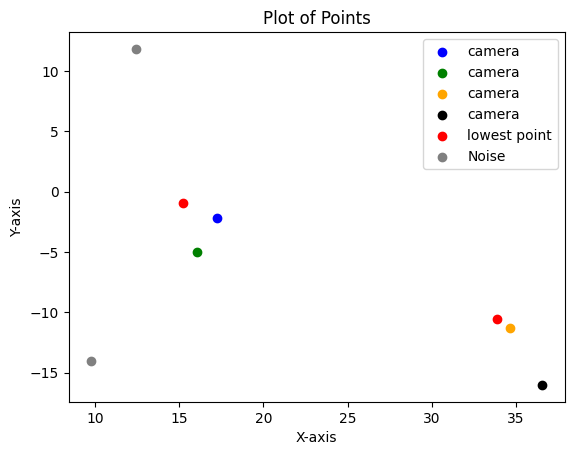

array([[          1,           0,           0,           0],
       [          0,           0,           0,           0]])
{'associated': [[array([          3,      982.12,      331.47,      1210.1,       456.1,     0.95169], dtype=float32),
                 [[1106.1881738307002, 430.03194152749626],
                  [1030.4981023906453, 421.48434602881525],
                  [11.865386962890625]]]],
 'non_associated': {'Radar': [[[1425.129902630761, 299.29680950335296],
                               [1369.2632716973455, 301.4412184094224],
                               [11.363946914672852]]],
                    'YOLO': [array([          3,      1252.2,      347.33,      1432.4,      474.41,     0.95122], dtype=float32),
                             array([          3,      1331.5,      259.57,      1421.5,      324.36,     0.92116], dtype=float32),
                             array([          3,      1491.4,      257.45,      1563.8,      316.54,     0.88315], dtype=float32)]}}



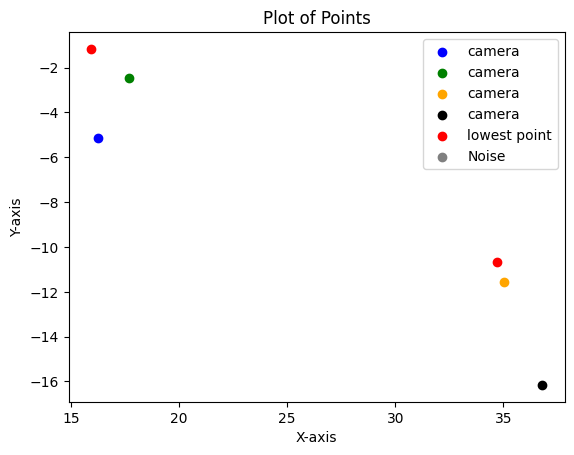

array([[          0,           1,           0,           0],
       [          0,           0,           1,           0]])
{'associated': [[array([          3,      1001.1,      328.14,      1219.4,      449.09,     0.94801], dtype=float32),
                 [[1109.810777744935, 387.7329543391657],
                  [1046.806017333127, 432.49117765321046],
                  [11.251152038574219]]],
                [array([          3,      1336.4,      259.05,      1424.3,      322.95,     0.91617], dtype=float32),
                 [[1384.9632685067959, 294.21763665241315],
                  [1363.4744449069844, 282.3368215421717],
                  [10.26860237121582]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,      1257.7,      346.02,      1435.5,      470.91,     0.94821], dtype=float32),
                             array([          3,      1492.7,      256.91,      1564.4,      315.68,     0.88331], dtype=float32)]}}

image 1/1 C:\Dk\Proje

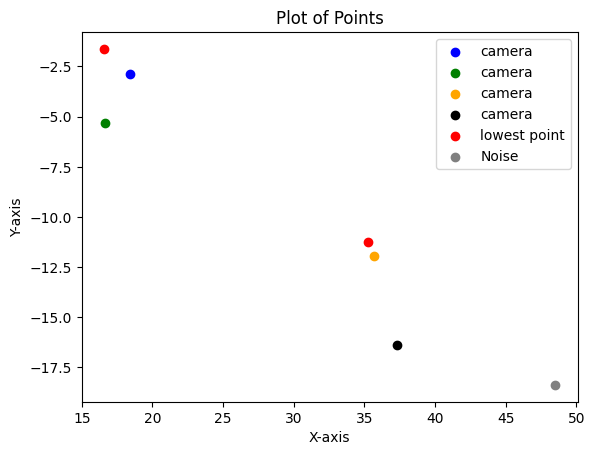

array([[          1,           0,           0,           0],
       [          0,           0,           0,           0]])
{'associated': [[array([          3,      1032.3,       322.4,      1236.2,       438.8,     0.93833], dtype=float32),
                 [[1143.503755288187, 409.1171948733494],
                  [1079.5309092444904, 416.0993846192957],
                  [11.575796127319336]]]],
 'non_associated': {'Radar': [[[1444.0975076886016, 293.64777167196763],
                               [1378.1747688278824, 298.0463609001636],
                               [11.344643592834473]]],
                    'YOLO': [array([          3,      1267.3,      342.19,      1440.9,      464.23,     0.93671], dtype=float32),
                             array([          3,      1342.9,      256.64,      1429.8,      320.51,     0.91635], dtype=float32),
                             array([          3,      1494.2,       256.4,      1564.7,      314.07,     0.88228], dtype=float32)]}}

im

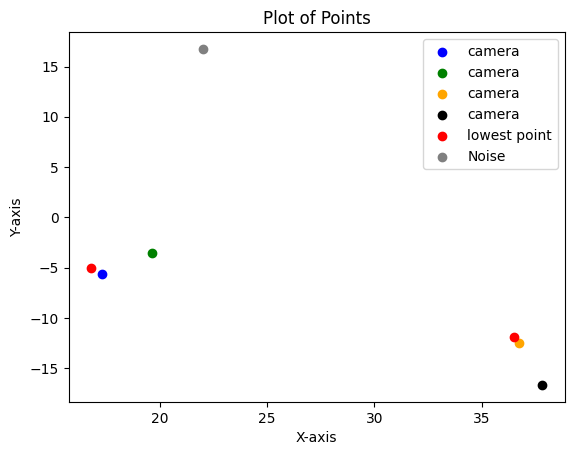

array([[          0,           1,           0,           0],
       [          0,           0,           0,           0]])
{'associated': [[array([          3,      1074.1,      317.34,      1260.6,      423.81,     0.94429], dtype=float32),
                 [[1199.9671205657794, 360.35313908841476],
                  [1351.4105995834666, 392.2568232962397],
                  [10.885685920715332]]]],
 'non_associated': {'Radar': [[[1458.9321129459652, 294.0915377744754],
                               [1388.6662876566543, 299.600462165498],
                               [10.591114044189453]]],
                    'YOLO': [array([          3,      1281.4,      337.91,      1448.2,      453.92,     0.94694], dtype=float32),
                             array([          3,      1353.5,      254.51,      1436.9,      316.85,     0.90717], dtype=float32),
                             array([          3,      1496.7,      255.77,        1566,      312.43,     0.88673], dtype=float32)]}}

im

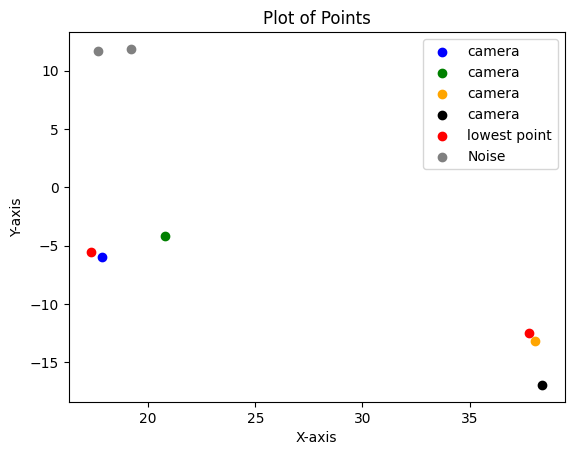

array([[          0,           1,           0,           0],
       [          0,           0,           0,           0]])
{'associated': [[array([          3,      1111.1,       306.4,      1282.1,      411.01,     0.93606], dtype=float32),
                 [[1232.109041029444, 377.3555861212612],
                  [1370.6606145049752, 414.32644003722686],
                  [11.751063346862793]]]],
 'non_associated': {'Radar': [[[1479.2458238164159, 254.99683444782235],
                               [1396.7145867036234, 283.8293333186541],
                               [10.586217880249023]]],
                    'YOLO': [array([          3,        1294,      333.93,      1455.3,      445.69,     0.94162], dtype=float32),
                             array([          3,      1363.1,      253.16,      1443.2,      312.73,     0.89774], dtype=float32),
                             array([          3,      1498.8,      254.57,      1566.7,      310.69,     0.89592], dtype=float32)]}}

i

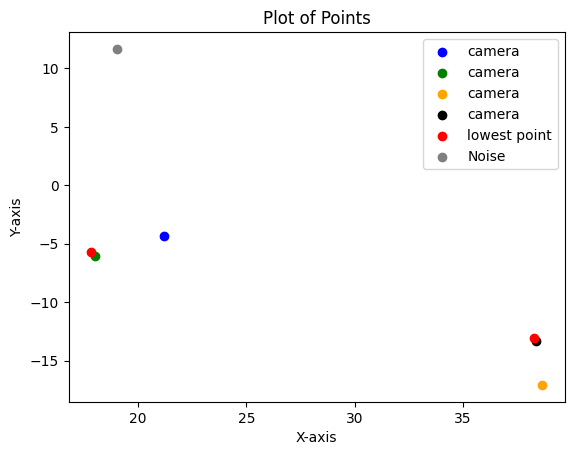

array([[          0,           0,           0,           0],
       [          0,           0,           0,           0]])
{'associated': [],
 'non_associated': {'Radar': [[[1297.547103212233, 351.1553761898905],
                               [1398.7456269193603, 89.68155294186982],
                               [9.668275833129883]],
                              [[1449.0911222714128, 288.24813396077946],
                               [1411.4767972470158, 275.26505958587387],
                               [11.872278213500977]]],
                    'YOLO': [array([          3,      1121.2,       305.1,      1288.4,      407.09,      0.9391], dtype=float32),
                             array([          3,      1297.8,       331.8,        1457,      443.45,     0.93795], dtype=float32),
                             array([          3,      1499.5,      254.07,      1567.2,      309.88,     0.89891], dtype=float32),
                             array([          3,      1366.1,      2

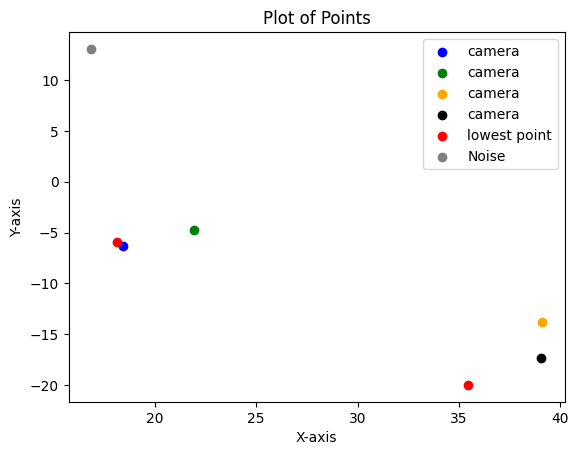

array([[          0,           1,           0,           0],
       [          0,           0,           0,           1]])
{'associated': [[array([          3,      1143.1,      300.34,        1301,      399.99,     0.93461], dtype=float32),
                 [[1245.0108696493446, 363.19223041809363],
                  [1383.2154108075613, 372.7256025571749],
                  [10.378408432006836]]],
                [array([          3,      1500.7,      253.55,      1568.6,      308.63,     0.90268], dtype=float32),
                 [[1523.087179218431, 300.16754160540586],
                  [1687.7412789243779, 440.67231532260854],
                  [7.875154495239258]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,      1307.4,      328.78,      1462.2,      438.01,     0.93563], dtype=float32),
                             array([          3,        1372,      251.35,      1450.4,      309.47,      0.9069], dtype=float32)]}}

image 1/1 C:\Dk\Pro

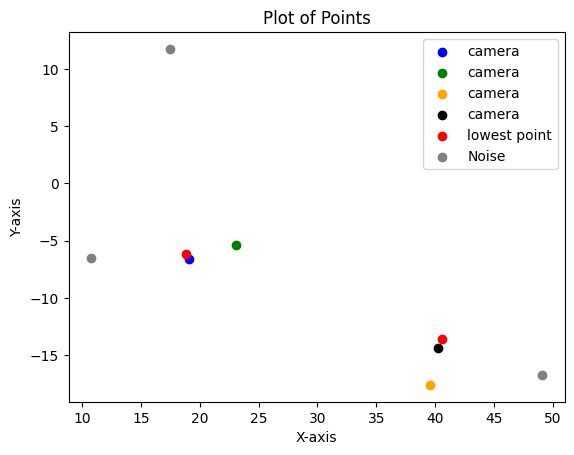

array([[          0,           1,           0,           0],
       [          0,           0,           0,           1]])
{'associated': [[array([          3,      1170.7,      297.52,      1317.2,      389.28,     0.92138], dtype=float32),
                 [[1273.2727957598822, 346.19814053977353],
                  [1379.6731090498783, 393.1288977176788],
                  [10.887482643127441]]],
                [array([          3,      1380.7,       249.6,      1456.8,      306.18,     0.90207], dtype=float32),
                 [[1454.7122272904635, 276.7959571234998],
                  [1400.4250231283972, 273.8697128002526],
                  [11.762933731079102]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,      1317.8,       324.9,      1467.9,      429.77,      0.9394], dtype=float32),
                             array([          3,      1502.9,      252.82,      1570.2,      307.15,      0.9041], dtype=float32)]}}

image 1/1 C:\Dk\Pro

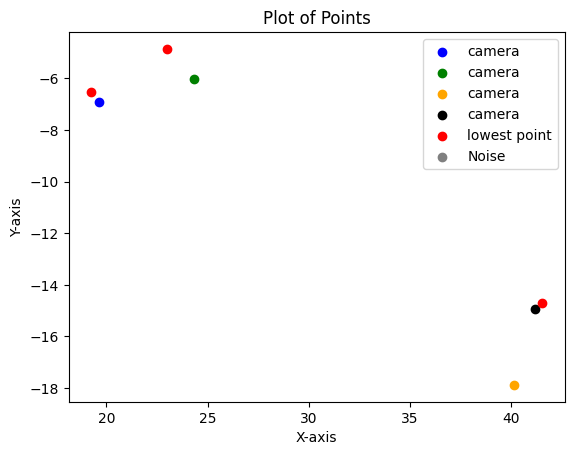

array([[          0,           0,           0,           0],
       [          0,           0,           0,           0],
       [          0,           0,           1,           0]])
{'associated': [[array([          3,      1505.5,      251.85,      1571.4,      305.58,     0.89874], dtype=float32),
                 [[1521.5049252661684, 275.38497950241367],
                  [1428.0393962037617, 272.3445845619153],
                  [8.394072532653809]]]],
 'non_associated': {'Radar': [[[1388.6058136995289, 284.0388370061519],
                               [1398.4427130074523, 396.7432153142639],
                               [7.156106472015381]],
                              [[1225.1065623091145, 382.6274533211868],
                               [1231.241932407096, 342.9528710508059],
                               [13.697443008422852]]],
                    'YOLO': [array([          3,      1329.4,      320.18,      1474.1,      422.91,      0.9394], dtype=float32),
          

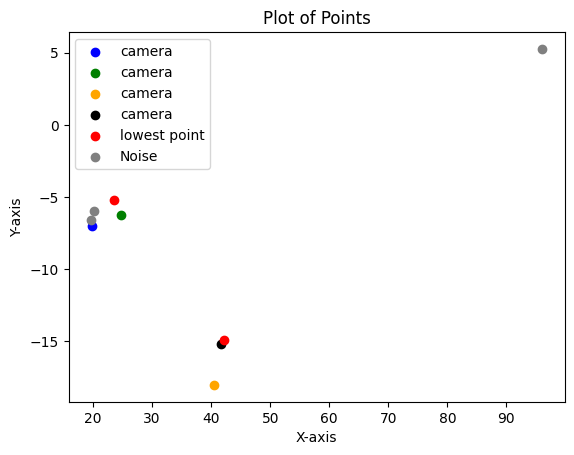

array([[          0,           1,           0,           0],
       [          0,           0,           0,           0]])
{'associated': [[array([          3,      1203.8,      292.29,      1337.5,      376.85,     0.92547], dtype=float32),
                 [[1281.211256426902, 368.09575932952697],
                  [1243.9449763561513, 342.241379071982],
                  [13.811782836914062]]]],
 'non_associated': {'Radar': [[[1481.939824016515, 270.7613516132514],
                               [1427.4545794064807, 263.46071995563807],
                               [10.514023780822754]]],
                    'YOLO': [array([          3,      1334.1,      318.07,      1475.5,      420.39,     0.93867], dtype=float32),
                             array([          3,      1506.1,      252.01,      1571.6,      304.79,     0.89746], dtype=float32),
                             array([          3,      1391.6,      247.78,      1465.1,      302.14,     0.89435], dtype=float32)]}}

ima

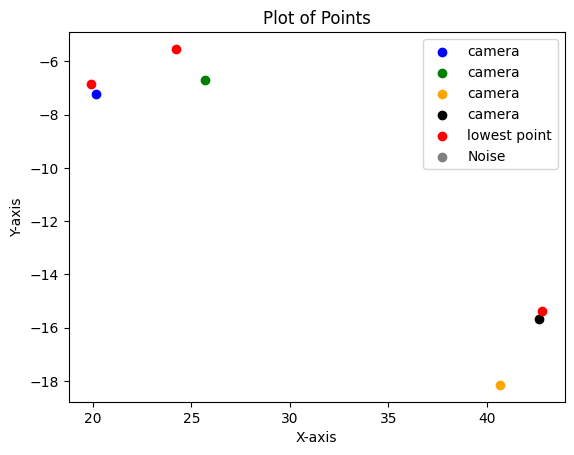

array([[          1,           0,           0,           0],
       [          0,           1,           0,           0],
       [          0,           0,           0,           0]])
{'associated': [[array([          3,      1341.5,      315.27,      1479.5,      416.46,     0.93134], dtype=float32),
                 [[1380.0332004834136, 378.1009374708659],
                  [1406.6686708657132, 391.73108187764706],
                  [7.117399215698242]]],
                [array([          3,        1219,      289.39,      1346.6,      369.75,     0.92341], dtype=float32),
                 [[1256.6088589411345, 359.0837924421897],
                  [1254.2046798035512, 337.53917563102124],
                  [11.706844329833984]]]],
 'non_associated': {'Radar': [[[1483.4641367139925, 288.7758260973991],
                               [1434.5766368330026, 272.8347799110034],
                               [8.074386596679688]]],
                    'YOLO': [array([          3,      1507

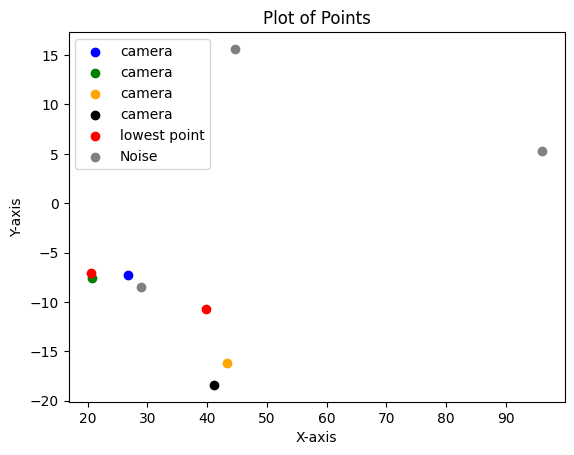

array([[          0,           1,           0,           0],
       [          0,           0,           1,           0]])
{'associated': [[array([          3,      1351.1,      310.83,      1484.8,      410.89,     0.92248], dtype=float32),
                 [[1422.0410044843934, 377.28729580611264],
                  [1404.7994703625493, 398.69098797683563],
                  [7.088218688964844]]],
                [array([          3,      1404.3,         244,      1473.9,      297.98,     0.88979], dtype=float32),
                 [[1454.9751271381535, 281.18150852820423],
                  [1311.1538150157558, 283.4752008302672],
                  [10.615804672241211]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,      1239.2,      285.78,      1360.1,      362.54,      0.9269], dtype=float32),
                             array([          3,      1508.5,      250.83,      1573.5,      302.86,     0.88557], dtype=float32)]}}

image 1/1 C:\Dk\Pr

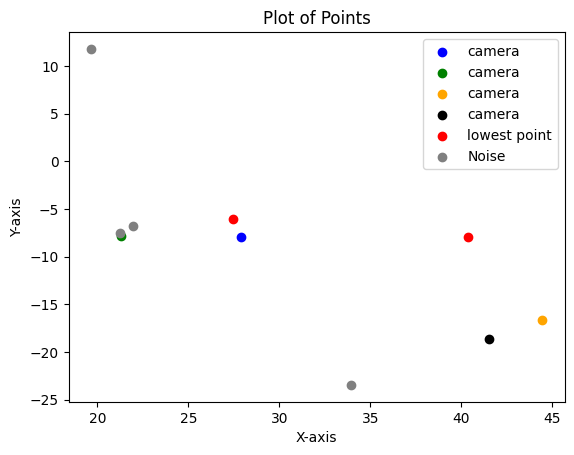

array([[          1,           0,           0,           0],
       [          0,           0,           0,           0]])
{'associated': [[array([          3,      1256.9,      281.77,      1372.6,      355.75,     0.92265], dtype=float32),
                 [[1297.5770478572692, 313.17772014955],
                  [1242.741906798603, 328.42364872129764],
                  [13.791937828063965]]]],
 'non_associated': {'Radar': [[[1489.588995792576, 286.8510910638125],
                               [1207.983884958517, 339.85632238619087],
                               [8.897964477539062]]],
                    'YOLO': [array([          3,      1358.7,      308.08,      1489.3,         405,      0.9148], dtype=float32),
                             array([          3,      1410.9,      242.74,      1478.6,      295.57,     0.87787], dtype=float32),
                             array([          3,      1510.1,      250.67,      1574.6,      301.75,     0.86066], dtype=float32)]}}

image 

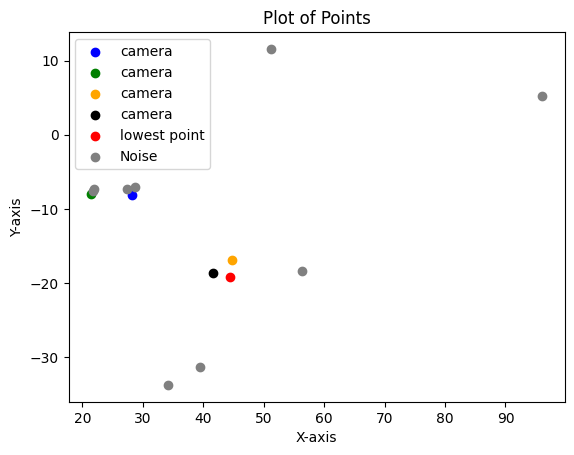

array([[          0,           0,           1,           0]])
{'associated': [[array([          3,      1413.7,      241.83,      1479.8,      294.68,     0.87121], dtype=float32),
                 [[1474.3947769467513, 268.88808206527784],
                  [1532.4670931457852, 307.391095708371],
                  [12.109854698181152]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,        1263,      279.87,      1376.6,      353.61,     0.91906], dtype=float32),
                             array([          3,      1361.6,      307.21,      1491.3,       403.3,     0.91237], dtype=float32),
                             array([          3,      1510.7,       249.8,      1574.7,      301.46,     0.85562], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-14-681.png: 416x640 4 cars, 67.0ms
Speed: 2.5ms preprocess, 67.0ms inference, 3.0ms postpr

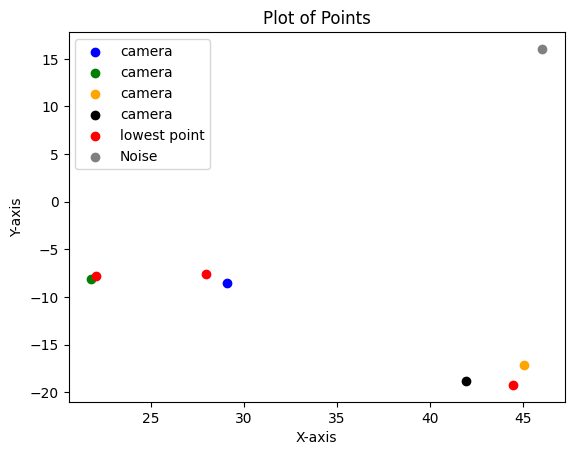

array([[          0,           1,           0,           0],
       [          0,           0,           0,           0],
       [          0,           0,           0,           1]])
{'associated': [[array([          3,      1366.5,      304.25,      1494.4,      399.99,     0.89195], dtype=float32),
                 [[1434.209107604209, 373.1385415592584],
                  [1421.0626319444934, 387.43800814320645],
                  [7.032041072845459]]],
                [array([          3,      1511.5,      249.91,      1575.2,      300.68,     0.84089], dtype=float32),
                 [[1574.7806705111768, 257.7511487829475],
                  [1534.6998696749092, 276.0928434885629],
                  [7.933200359344482]]]],
 'non_associated': {'Radar': [[[1298.4335093337102, 351.89331489961495],
                               [1310.135172972842, 343.8977971088185],
                               [13.78352165222168]]],
                    'YOLO': [array([          3,        1274,

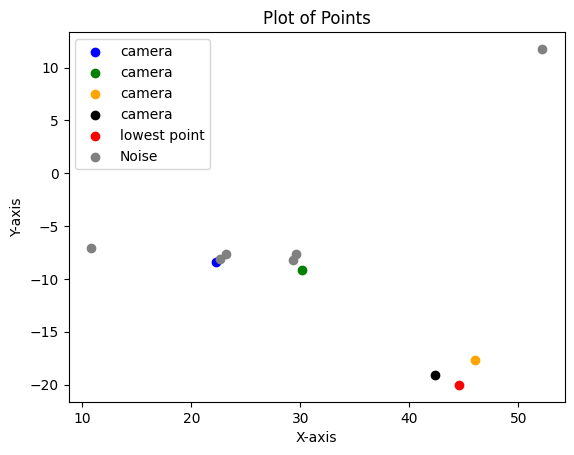

array([[          0,           0,           0,           1]])
{'associated': [[array([          3,      1513.5,       248.4,      1575.9,      299.69,     0.82857], dtype=float32),
                 [[1519.1300303818518, 281.8528375468522],
                  [1556.7112893060078, 284.27599139630513],
                  [8.797462463378906]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,      1372.7,      301.24,      1499.6,      395.24,       0.887], dtype=float32),
                             array([          3,      1289.4,      272.98,      1394.6,      343.59,     0.88693], dtype=float32),
                             array([          3,      1423.4,      238.54,      1489.7,       292.1,     0.84588], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-14-881.png: 416x640 4 cars, 68.0ms
Speed: 5.0ms preprocess, 68.0ms inference, 4.5ms postpr

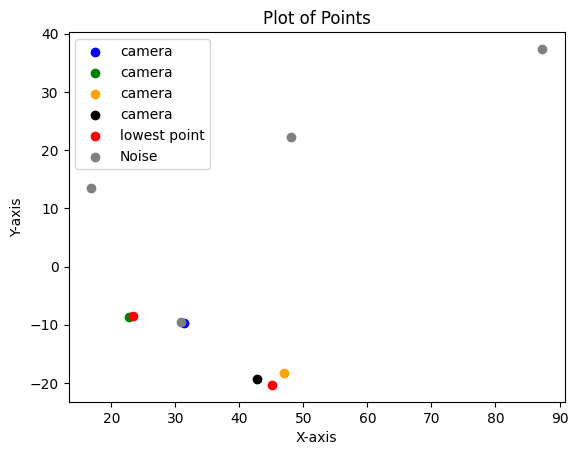

array([[          0,           1,           0,           0],
       [          0,           0,           1,           0]])
{'associated': [[array([          3,      1380.3,      298.65,      1503.4,      390.84,     0.88675], dtype=float32),
                 [[1423.3437766016077, 350.0401626494713],
                  [1433.413235544418, 337.70651723653384],
                  [6.952915191650391]]],
                [array([          3,      1429.7,      237.62,      1492.8,      289.99,     0.86251], dtype=float32),
                 [[1438.1747587795828, 269.5848729593351],
                  [1559.0021465130367, 280.86607604324985],
                  [9.897815704345703]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,      1302.8,      269.89,      1402.9,      338.03,     0.90095], dtype=float32),
                             array([          3,      1514.7,       247.1,      1576.7,      298.65,     0.83241], dtype=float32)]}}

image 1/1 C:\Dk\Proje

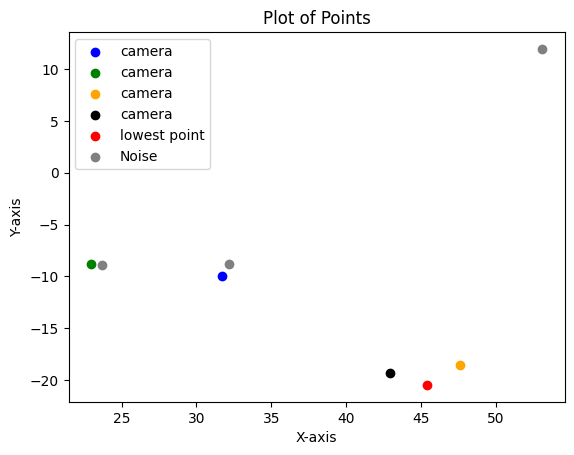

array([[          0,           0,           0,           0]])
{'associated': [],
 'non_associated': {'Radar': [[[1513.5466703507675, 276.8943204885767],
                               [1558.6600252916178, 282.36964294241676],
                               [10.346796035766602]]],
                    'YOLO': [array([          3,      1307.3,      269.25,        1406,       336.5,     0.90893], dtype=float32),
                             array([          3,      1382.9,      297.78,      1504.4,      389.42,     0.88577], dtype=float32),
                             array([          3,      1432.2,      237.24,      1495.6,      288.78,     0.86549], dtype=float32),
                             array([          3,      1515.2,      246.42,      1577.2,      298.21,     0.83658], dtype=float32)]}}

image 1/1 C:\Dk\Projects\Team Project\Dataset\INFRA-3DRC-Dataset\INFRA-3DRC_scene-15\camera_01\camera_01__data\camera_01__2023-06-02-21-28-14-981.png: 416x640 4 cars, 68.5ms
Speed: 4.0ms prepr

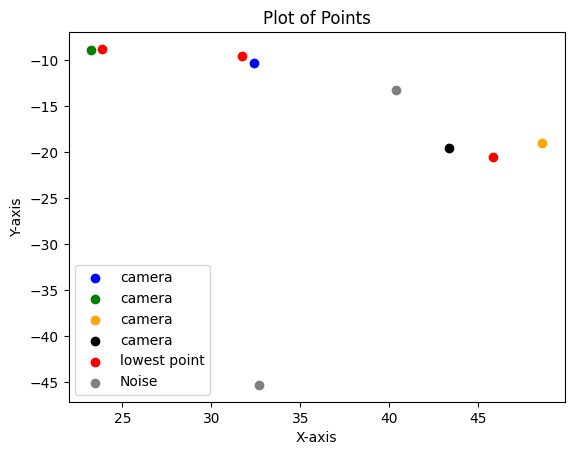

array([[          0,           1,           0,           0],
       [          1,           0,           0,           0],
       [          0,           0,           0,           0]])
{'associated': [[array([          3,      1387.8,      296.68,      1506.3,      387.08,     0.87709], dtype=float32),
                 [[1438.011469138851, 357.31970750894703],
                  [1442.2465400331207, 341.0623205911944],
                  [6.918447494506836]]],
                [array([          3,      1315.9,      267.27,      1413.5,      333.35,     0.89183], dtype=float32),
                 [[1347.0216384208163, 329.8026722800554],
                  [1353.5144622538226, 299.72347208070676],
                  [13.80044937133789]]]],
 'non_associated': {'Radar': [[[1270.5454919890851, 270.9003818427883],
                               [1554.1058407922678, 287.3304244076748],
                               [8.881453514099121]]],
                    'YOLO': [array([          3,      1435.9

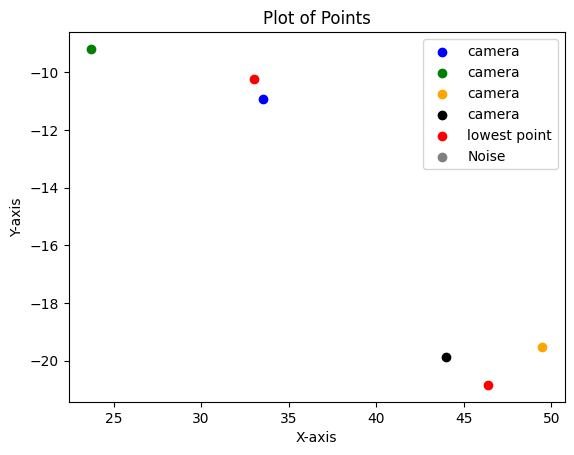

array([[          1,           0,           0,           0],
       [          0,           0,           0,           0]])
{'associated': [[array([          3,      1327.8,      265.88,      1420.8,      328.71,     0.88128], dtype=float32),
                 [[1359.2706767651096, 313.0766054418771],
                  [1366.6122599938137, 285.1916975748506],
                  [13.801918983459473]]]],
 'non_associated': {'Radar': [[[1296.7714600712072, 273.083324433454],
                               [1556.0618800135646, 288.2029897213651],
                               [8.736237525939941]]],
                    'YOLO': [array([          3,      1394.4,      293.89,      1509.9,      383.14,     0.87692], dtype=float32),
                             array([          3,      1441.3,      235.71,      1500.9,      285.17,     0.85695], dtype=float32),
                             array([          3,      1518.1,      245.89,      1577.9,       295.7,     0.83281], dtype=float32)]}}

imag

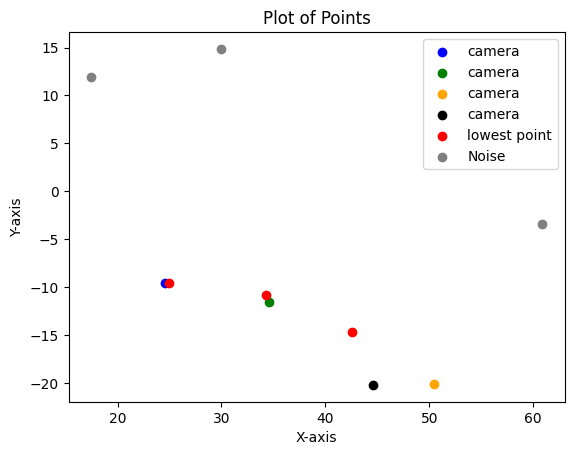

array([[          1,           0,           0,           0],
       [          0,           0,           0,           0],
       [          0,           0,           0,           0]])
{'associated': [[array([          3,      1400.6,      292.61,      1513.3,      376.87,     0.88001], dtype=float32),
                 [[1453.086383871872, 368.7258240785064],
                  [1461.1950864144374, 346.25328072335174],
                  [6.852111339569092]]]],
 'non_associated': {'Radar': [[[1378.2007261833933, 253.6276399779851],
                               [1372.7416882501973, 299.7135460953365],
                               [13.833759307861328]],
                              [[1348.4106894779538, 251.62152771380522],
                               [1439.9987177567011, 19.593895119323737],
                               [8.782207489013672]]],
                    'YOLO': [array([          3,      1338.9,      264.05,      1428.2,      324.46,     0.87164], dtype=float32),
        

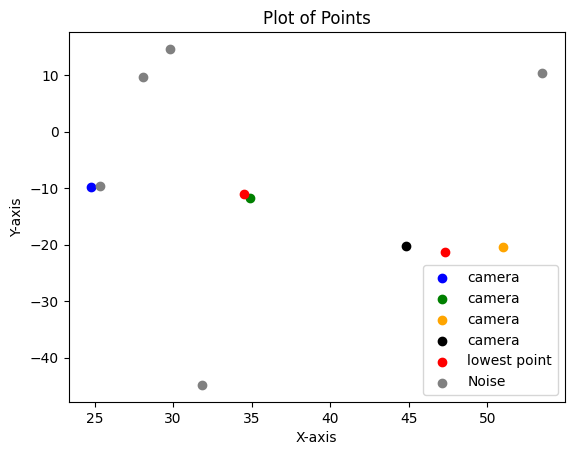

array([[          0,           1,           0,           0],
       [          0,           0,           0,           1]])
{'associated': [[array([          3,      1342.6,      263.19,      1430.3,      323.26,     0.87019], dtype=float32),
                 [[1374.1735805176963, 279.8672126444486],
                  [1408.846068961571, -45.90158030456923],
                  [13.799118041992188]]],
                [array([          3,      1519.5,      245.05,      1579.1,      293.81,     0.83564], dtype=float32),
                 [[1521.7726675431052, 265.2527622698743],
                  [1557.8834525631223, 280.8054377145774],
                  [8.878588676452637]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,      1402.5,      291.82,      1514.1,      375.05,     0.87997], dtype=float32),
                             array([          3,      1449.6,      234.62,      1505.6,      282.39,     0.84067], dtype=float32)]}}

image 1/1 C:\Dk\Proje

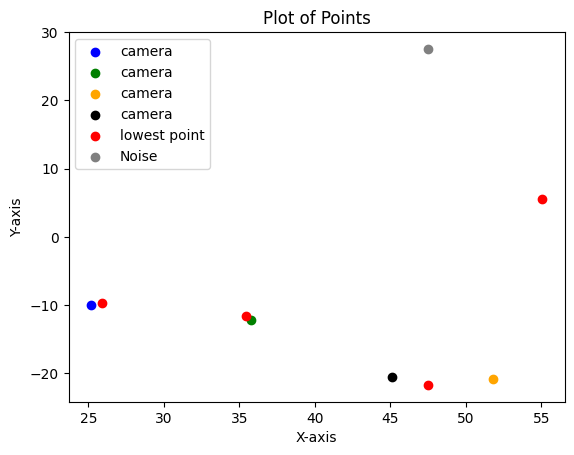

array([[          0,           0,           1,           0],
       [          0,           1,           0,           0],
       [          0,           0,           0,           1],
       [          0,           0,           0,           0]])
{'associated': [[array([          3,      1452.3,      234.45,      1507.7,      281.03,     0.86467], dtype=float32),
                 [[1473.8455986626695, 241.01919835762084],
                  [1486.132244387529, -0.11402499167228687],
                  [6.847873687744141]]],
                [array([          3,      1349.1,       262.1,      1435.6,      320.22,     0.87124], dtype=float32),
                 [[1374.8141482520696, 315.5645444659276],
                  [1388.102937627854, 304.2167497787115],
                  [13.806254386901855]]],
                [array([          3,      1520.7,      244.61,      1579.7,      293.13,     0.83489], dtype=float32),
                 [[1554.542117831448, 261.3750000299555],
                  [

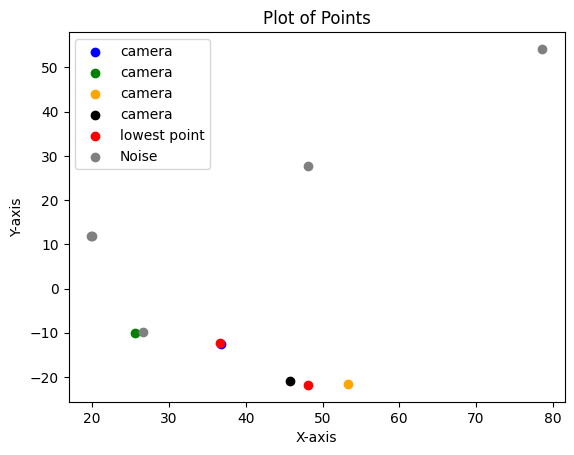

array([[          1,           0,           0,           0],
       [          0,           0,           1,           0]])
{'associated': [[array([          3,      1358.1,       260.4,      1441.7,      316.81,     0.88033], dtype=float32),
                 [[1383.7570319326728, 307.0534575421189],
                  [1397.6962656035134, 295.62895019984745],
                  [13.801671981811523]]],
                [array([          3,      1457.7,      233.42,        1511,      278.54,      0.8643], dtype=float32),
                 [[1487.5697677810817, 257.92054747390904],
                  [1562.8718570021354, 277.46845479273435],
                  [8.325206756591797]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,      1412.8,      288.32,      1518.3,      369.38,     0.87889], dtype=float32),
                             array([          3,      1521.9,      243.51,      1580.2,      291.66,     0.83584], dtype=float32)]}}

image 1/1 C:\Dk\Pr

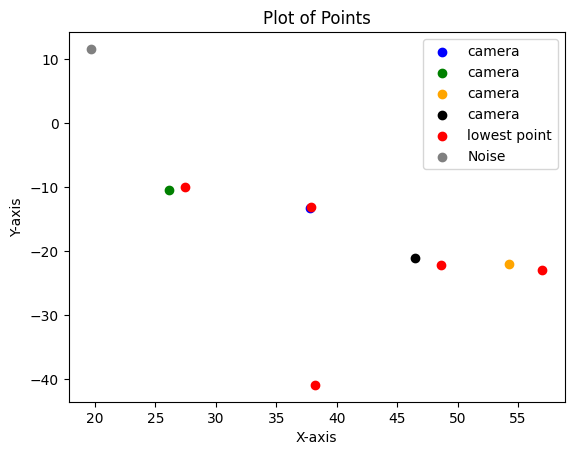

array([[          0,           1,           0,           0],
       [          1,           0,           0,           0],
       [          0,           0,           0,           1],
       [          0,           0,           0,           0],
       [          0,           0,           1,           0]])
{'associated': [[array([          3,      1418.2,      286.78,      1522.1,      365.43,     0.86892], dtype=float32),
                 [[1455.4354821753204, 341.17301274503683],
                  [1433.3258892368028, 312.9308417437218],
                  [6.7223076820373535]]],
                [array([          3,      1367.3,      259.05,      1446.9,      313.38,     0.88417], dtype=float32),
                 [[1392.3866662050266, 310.2919768116468],
                  [1411.4275925252145, 301.5320022986053],
                  [13.79116439819336]]],
                [array([          3,      1522.6,      241.88,        1581,      290.32,     0.83135], dtype=float32),
                 

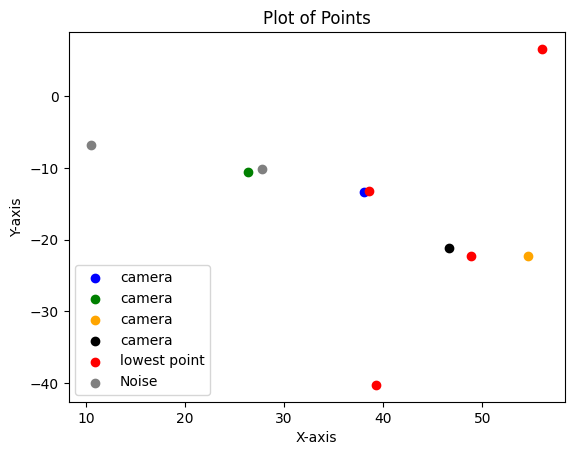

array([[          1,           0,           0,           0],
       [          0,           0,           0,           1],
       [          0,           0,           0,           0],
       [          0,           0,           0,           0]])
{'associated': [[array([          3,      1370.2,      258.28,      1448.8,      312.53,     0.88394], dtype=float32),
                 [[1407.3936526311184, 304.04999661527967],
                  [1407.5538390108156, 308.6212637096009],
                  [13.839780807495117]]],
                [array([          3,      1522.8,      241.65,      1581.2,      289.97,     0.83053], dtype=float32),
                 [[1568.1519486339073, 281.3359399442992],
                  [1567.1136513206766, 277.62166570544144],
                  [6.005274772644043]]]],
 'non_associated': {'Radar': [[[2325.2881730281756, 292.34860647943503],
                               [2325.2881730281756, 292.34860647943503],
                               [5.740848541259766

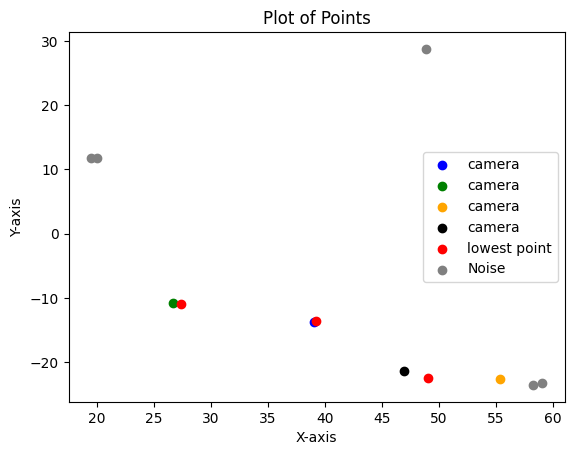

array([[          0,           0,           0,           0],
       [          1,           0,           0,           0],
       [          0,           0,           0,           1]])
{'associated': [[array([          3,      1374.9,      257.27,      1452.4,       309.7,     0.88034], dtype=float32),
                 [[1406.5850065305826, 301.69117289964385],
                  [1412.3864345632496, 306.38386767412334],
                  [13.82641315460205]]],
                [array([          3,      1523.4,      241.31,      1581.4,      289.38,     0.82977], dtype=float32),
                 [[1569.062053997924, 255.50508763113334],
                  [1567.890039443121, 276.47462704224864],
                  [6.00040864944458]]]],
 'non_associated': {'Radar': [[[1461.8376702299713, 371.0993518972831],
                               [1477.5881660046975, 366.3661704510164],
                               [6.702744960784912]]],
                    'YOLO': [array([          3,      1423.4

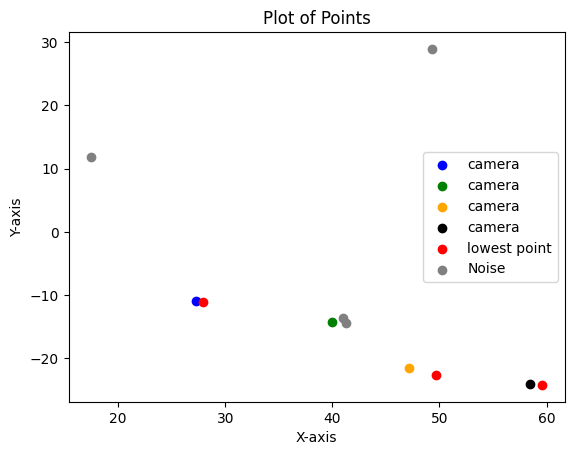

array([[          1,           0,           0,           0],
       [          0,           0,           0,           0],
       [          0,           0,           0,           1]])
{'associated': [[array([          3,      1427.6,      284.42,      1526.6,      358.52,     0.88181], dtype=float32),
                 [[1469.271408137889, 330.0943278861646],
                  [1478.051732600325, 347.04194139765343],
                  [6.694353103637695]]],
                [array([          3,      1470.1,      232.87,      1520.1,      271.23,     0.82804], dtype=float32),
                 [[1505.1707039363807, 252.17708670880808],
                  [1502.7378868800156, 247.68720430037806],
                  [14.564644813537598]]]],
 'non_associated': {'Radar': [[[1584.038143388142, 296.26537212044576],
                               [1566.3805518698678, 270.76465469695705],
                               [4.965461254119873]]],
                    'YOLO': [array([          3,        13

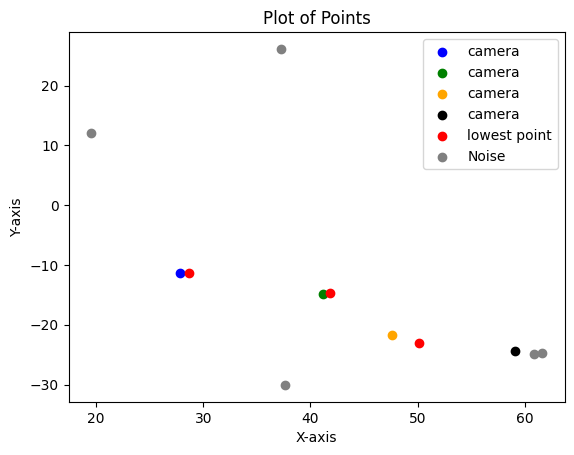

array([[          1,           0,           0,           0],
       [          0,           1,           0,           0],
       [          0,           0,           1,           0]])
{'associated': [[array([          3,      1432.6,      282.99,        1529,      355.18,     0.87621], dtype=float32),
                 [[1480.0081222732804, 338.5282729809334],
                  [1481.3447644442494, 350.13027651456855],
                  [6.669200897216797]]],
                [array([          3,      1391.2,       254.9,      1461.1,      303.64,     0.85116], dtype=float32),
                 [[1419.1820749615863, 292.12555647337325],
                  [1427.878557169823, 264.14645419941724],
                  [13.884440422058105]]],
                [array([          3,        1526,      239.96,        1583,      288.03,     0.82357], dtype=float32),
                 [[1577.8408658319363, 241.8616755131463],
                  [1574.0162309046716, 265.05236990531984],
                  [

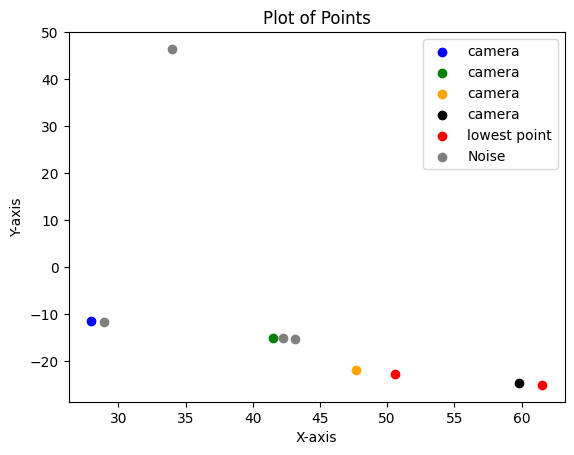

array([[          0,           0,           1,           0],
       [          0,           0,           0,           1]])
{'associated': [[array([          3,      1526.3,      239.72,      1583.2,      287.85,     0.82082], dtype=float32),
                 [[1570.1773494249474, 243.8727653948077],
                  [1560.0238383501348, 278.3237943771656],
                  [5.879004955291748]]],
                [array([          3,      1474.2,      230.91,      1521.5,      269.45,      0.8128], dtype=float32),
                 [[1509.7168306332567, 246.5778224765258],
                  [1499.8928387983804, 272.26288112938096],
                  [14.59717082977295]]]],
 'non_associated': {'Radar': [],
                    'YOLO': [array([          3,      1434.6,      282.33,      1529.9,       354.3,     0.87356], dtype=float32),
                             array([          3,      1393.5,      254.11,      1462.8,       302.7,     0.84753], dtype=float32)]}}

image 1/1 C:\Dk\Proje

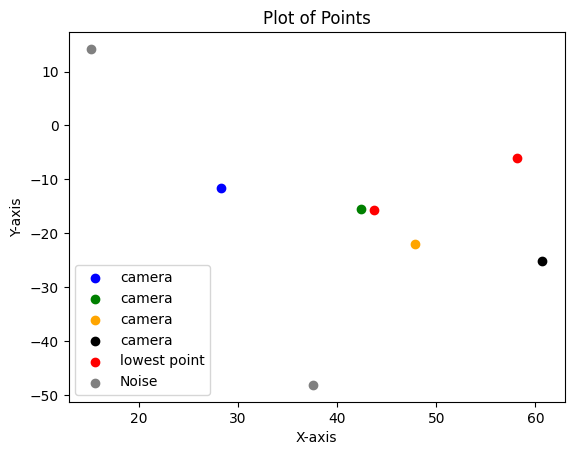

array([[          0,           0,           0,           1],
       [          0,           0,           0,           0]])
{'associated': [[array([          3,      1476.4,      231.36,      1523.1,      268.38,     0.80085], dtype=float32),
                 [[1496.73374367993, 264.714176349579],
                  [1432.1700386883365, 295.2289879127964],
                  [10.247177124023438]]]],
 'non_associated': {'Radar': [[[1375.316189797493, 252.18722613712785],
                               [1080.9767336206594, 255.5199458158266],
                               [11.659133911132812]]],
                    'YOLO': [array([          3,      1437.8,      281.17,        1532,      352.37,     0.88119], dtype=float32),
                             array([          3,      1397.9,       253.3,      1465.5,      300.42,     0.83843], dtype=float32),
                             array([          3,      1527.3,       239.4,      1584.2,       287.4,     0.81936], dtype=float32)]}}

image

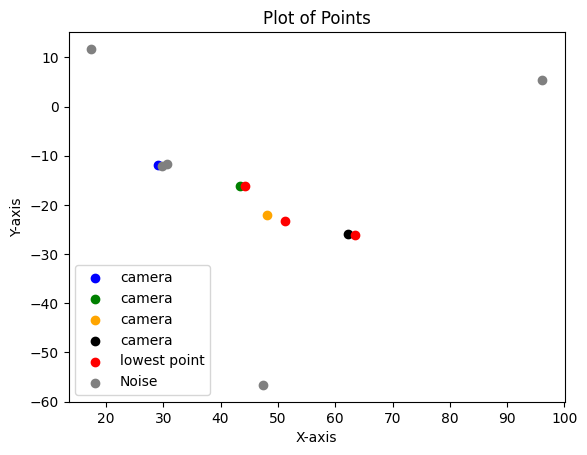

array([[          0,           1,           0,           0],
       [          0,           0,           1,           0],
       [          0,           0,           0,           0]])
{'associated': [[array([          3,      1405.1,      251.36,      1471.5,      297.88,     0.84827], dtype=float32),
                 [[1440.452283778861, 278.1432972012296],
                  [1441.6799636825372, 256.0244787486738],
                  [13.886662483215332]]],
                [array([          3,      1528.9,      239.11,      1585.4,      287.02,     0.84563], dtype=float32),
                 [[1566.3274751948793, 256.63559974505813],
                  [1566.5773793456804, 268.6455430217482],
                  [5.727189064025879]]]],
 'non_associated': {'Radar': [[[1342.489076143251, 244.74274084782965],
                               [1510.539707634271, 241.62818117620668],
                               [12.491789817810059]]],
                    'YOLO': [array([          3,      1442.

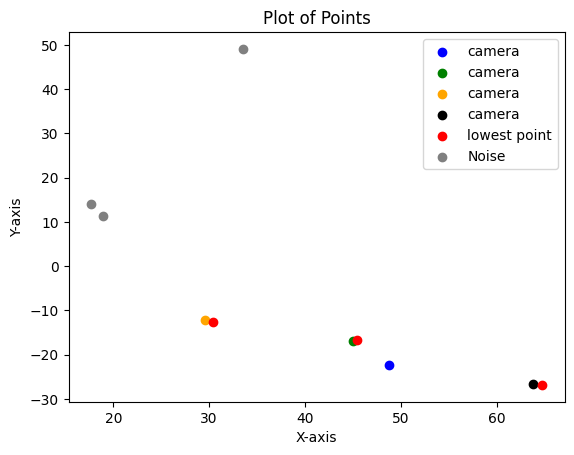

array([[          0,           0,           1,           0],
       [          0,           1,           0,           0],
       [          0,           0,           0,           0]])
{'associated': [[array([          3,      1445.7,      278.77,        1537,      345.52,     0.85609], dtype=float32),
                 [[1479.803219967289, 343.5810250137879],
                  [1501.8965364280082, 322.1045819799016],
                  [6.611601829528809]]],
                [array([          3,      1411.9,      249.41,      1474.2,      294.34,     0.86244], dtype=float32),
                 [[1469.238252144899, 271.57948409347193],
                  [1445.3827298048668, 274.7450924246256],
                  [12.101027488708496]]]],
 'non_associated': {'Radar': [[[1409.5464813720582, 243.59790956396122],
                               [1514.3595429805926, 240.36709882832076],
                               [14.528999328613281]]],
                    'YOLO': [array([          3,        15

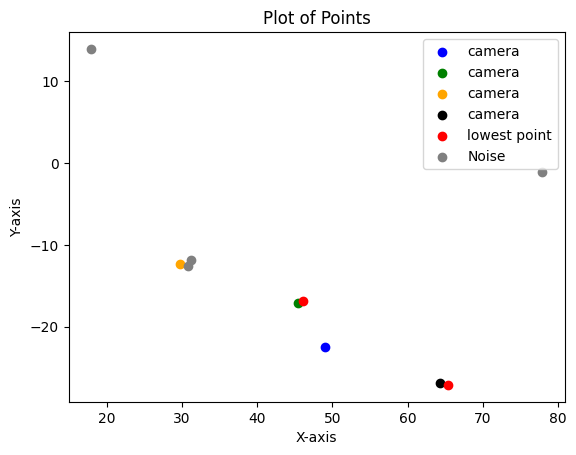

array([[          0,           0,           0,           0],
       [          0,           0,           0,           1]])
{'associated': [[array([          3,      1483.9,      231.23,      1526.6,      264.13,     0.77718], dtype=float32),
                 [[1513.1896969533484, 240.2042890857885],
                  [1514.8151605731427, 235.4158517405574],
                  [14.608087539672852]]]],
 'non_associated': {'Radar': [[[1527.3560661848394, 277.3885823780089],
                               [1445.369469635314, 274.7690227861386],
                               [9.804841995239258]]],
                    'YOLO': [array([          3,      1530.5,      238.58,      1586.9,      285.31,     0.86907], dtype=float32),
                             array([          3,      1414.3,      248.89,      1475.8,       293.4,     0.85837], dtype=float32),
                             array([          3,      1446.8,      278.41,      1537.4,      344.74,     0.85737], dtype=float32)]}}


In [108]:
for img, pcd in zip(image_list, pcd_list):

    results = yolo_model.predict(img)
    list_of_pred_boxes = class_box_generator_for_pred(results)
    # print(list_of_pred_boxes)
    
    db_scan = my_custom_dbscan(eps1=0.1, eps2=0.5, min_samples=2)
    clusters_on_radar = db_scan.process_pcd_files(pcd)
    # print(clusters_on_radar)

    image_on_ground = homography(list_of_pred_boxes)
    clusters_on_ground = radar_to_ground(clusters_on_radar)
    clusters_on_image = radar_to_camera(clusters_on_radar)
    # print(clusters_on_image)
    # print(clusters_on_ground)
    
    #Plot on Ground Plane
    plot = camera_plotting(image_on_ground)
    plot2 = radar_plotting(clusters_on_ground, plot)
    plt.show(plot2)
    
    data_association = get_one_one_association(list_of_pred_boxes, clusters_on_image) 
    pprint(data_association)

    # Update_dict = homography(data_association['non_associated']['YOLO'])




    # euclidean_distances = get_association(image_on_ground, clusters)
    # print(euclidean_distances)

    # a = assign_objects(euclidean_distances)

    # hungarian = Hungarian(euclidean_distances)
    # hungarian.calculate() 
    # a = hungarian.get_results()
    